<a id='top'></a> 
# Healthcare Provider Fraud Detection 

#### Table of Contents
- [Background](#background)
- [Data Import](#import)
- [Exploratory Analysis](#eda)
    - [Missingness](#missing)
    - [Fraudulance Prevelance](#fraud)
    - [Race & Gender](#race_gender)
    - [Diagnosis & Procedure Codes](#codes)
    - [Date Analysis](#date)
    - [Medicare Part A/B](#medicare_part)
    - [Payments](#payments)
    - [Cummulative Features](#cummfeat)
- [Data Cleaning & Feature Engineering](#clean)
- [Data Preparation](#prep)
    - [Multicollinearity](#mcl)
    - [Encoding](#encoding)
- [Modeling](#model)
    - [Train-Test Split](#split)
    - [Upsampling](#upsampling)
    - [First Pass Modeling](#firstpass)
    - [Hyperparameter Tuning](#tuning)
    - [Model Analysis](#model_analysis)
- [Aggregating Predictions](#aggregate)



## Background <a id='background'></a>

[Kaggle Compitition](https://www.kaggle.com/rohitrox/healthcare-provider-fraud-detection-analysis)

[example](https://www.kaggle.com/rohitrox/medical-provider-fraud-detection/log)

[another example](https://nycdatascience.com/blog/student-works/certainty-and-healthcare-fraud/)


[How to spot fraud](https://www.medicare.gov/forms-help-resources/help-fight-medicare-fraud/how-spot-medicare-fraud)

[Common fraud techniques](http://blog.joinvanderbilt.com/spot-common-types-of-medicare-fraud)


[Claim group codes](https://www.cms.gov/icd10m/version38-0-R1-fullcode-cms/fullcode_cms/P0002.html)

[Diagnosis and Procedure Codes](https://www.cms.gov/Medicare/Coding/ICD9ProviderDiagnosticCodes/codes)




## Questions for Carolina
1. How do diagnosis / procedure codes work? (my googling has found something called the ICD-9-CM which seems to match up with the values in the dataset)
1. Do you recognize the terms "Claim Amdit Dianosis Code", or "Diagnosis Group Code"?
1. How standardized is the diagnositic -> procedure treatments. Would you expect the procedure codes could (somewhat) be predicted from the dianosis codes? Is there a standard procedure y given diagnosis x or is it very complicated?
1. Do you see any reason the claims start/end would differ from the admit/discharge date for inpatient claims? 
1. To your knowledge what level does medicare/insurance fraud happen at? Hospital, network, physican? Are there trainings about how to spot it?
1. Would you expect that Chronic conditions (Alzheimers, Heartfailure, Diabetes, etc) systemically effect diagnosis/procedure codes or are they more considerations?
1. Given the categories "Attending Physican, Operating Physician, & Other Physician" why might a single physician be listed in multiple sections?


# TO DO:
1. ML
1. Intake codes?
1. show that fraudulent have more days/people whatever

## Data Import <a id='import'></a>

[Back To Top](#top)

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import missingno as msno

In [2]:
file_list = ["Test-1542969243754.csv",
             "Test_Beneficiarydata-1542969243754.csv",
             "Test_Inpatientdata-1542969243754.csv",
             "Test_Outpatientdata-1542969243754.csv",
             "Train-1542865627584.csv",
             "Train_Beneficiarydata-1542865627584.csv",
             "Train_Inpatientdata-1542865627584.csv",
             "Train_Outpatientdata-1542865627584.csv"]

clean = str.maketrans("","","-0123456789")
file_names = [x.translate(clean).replace(".csv","") for x in file_list]


def custom_import(train_only = False):
    '''
    
    '''
    
    name_file_dict = dict()
    PATH          = "./data/"
    
    for name, file in zip(file_names,file_list):
        name_file_dict[name] = pd.read_csv(PATH+file)

    if train_only:
        return_dict = {key: value for key, value in name_file_dict.items() if key.startswith("Train")}
        return return_dict
    else:
        return name_file_dict
    
        
    
data_dict = custom_import(train_only=False)

In [3]:
prov_key = data_dict['Train']
prov_key = prov_key.replace({"No":0,"Yes":1})

Bene_data = data_dict['Train_Beneficiarydata']

dfs = [data_dict['Train_Inpatientdata'],data_dict['Train_Outpatientdata']]
keys = ['Inpatient',"Outpatient"]
Train_Patientdata = pd.concat([df.assign(Source=key).reset_index() for key, df in zip(keys,dfs)],axis=0, ignore_index=True).drop('index',axis=1)

claims = Train_Patientdata.merge(Bene_data,on="BeneID")
claims = claims.merge(prov_key,on='Provider')


def create_claims():
    data_dict = custom_import(train_only=True)
    prov_key  = data_dict['Train'].replace({"No":0,"Yes":1})
    Bene_data = data_dict['Train_Beneficiarydata']
    dfs       = [data_dict['Train_Inpatientdata'],data_dict['Train_Outpatientdata']]
    keys      = ['Inpatient',"Outpatient"]
    building  = pd.concat([df.assign(Source=key).reset_index() for key, df in zip(keys,dfs)],axis=0, ignore_index=True).drop('index',axis=1)
    building  = building.merge(Bene_data,on="BeneID")
    building  = building.merge(prov_key,on='Provider')

    return building

## Exploratory Analysis <a id='eda'></a>

[Back To Top](#top)

## Missing Data <a id='missing'></a>

Most missing data is intentional in our dataset. The beneficiary data includes only 1 feature with missingness, DOD (Date of Death), which is a great thing for the patients. 

Inpatient and Outpatiend data sets have a large degree of missingness built into the feature-space. Information about Physicians and Claims is incomplete when there was not a needed service. Interestingly the only missingness not explained by the feature is 899 DeductableAmtPaid values in the Inpatient data. This column has no missingness in the outpatient dataset. 

Missing Features & Count
 Series([], dtype: int64)


<AxesSubplot:>

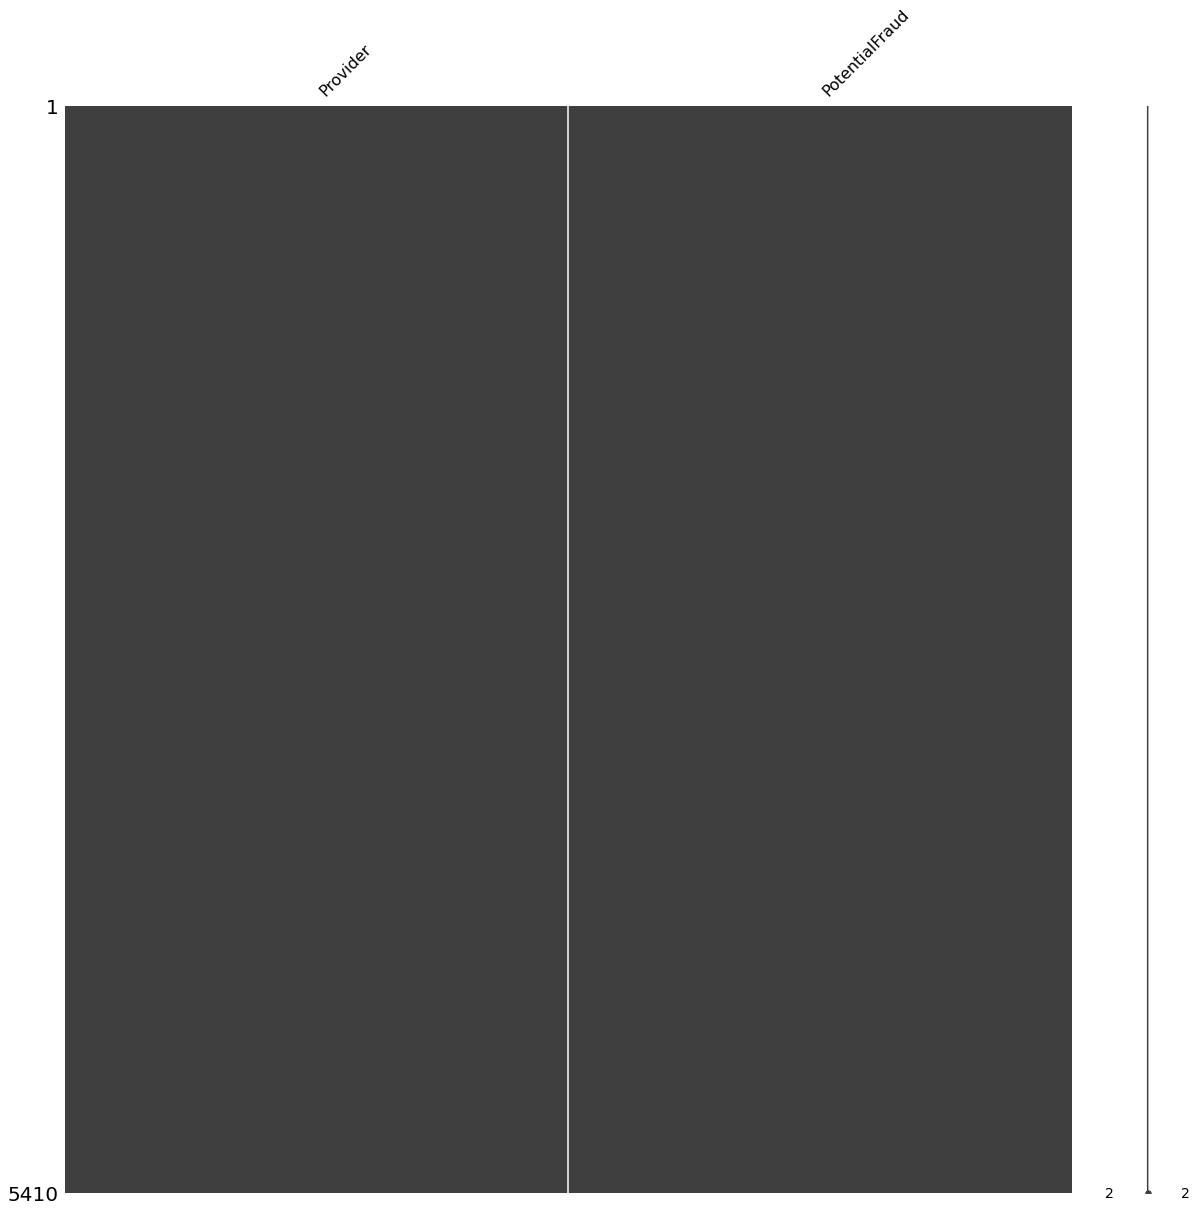

In [31]:
missing = data_dict['Train'].isna().sum(axis=0).sort_values(ascending=False)
print("Missing Features & Count\n",missing[missing!=0])
fig = msno.matrix(data_dict['Train'], figsize=(20,20))
fig_copy = fig.get_figure()
fig_copy.savefig('./graphics/msno_provider.png')
fig

Missing Features & Count
 DOD    137135
dtype: int64


<AxesSubplot:>

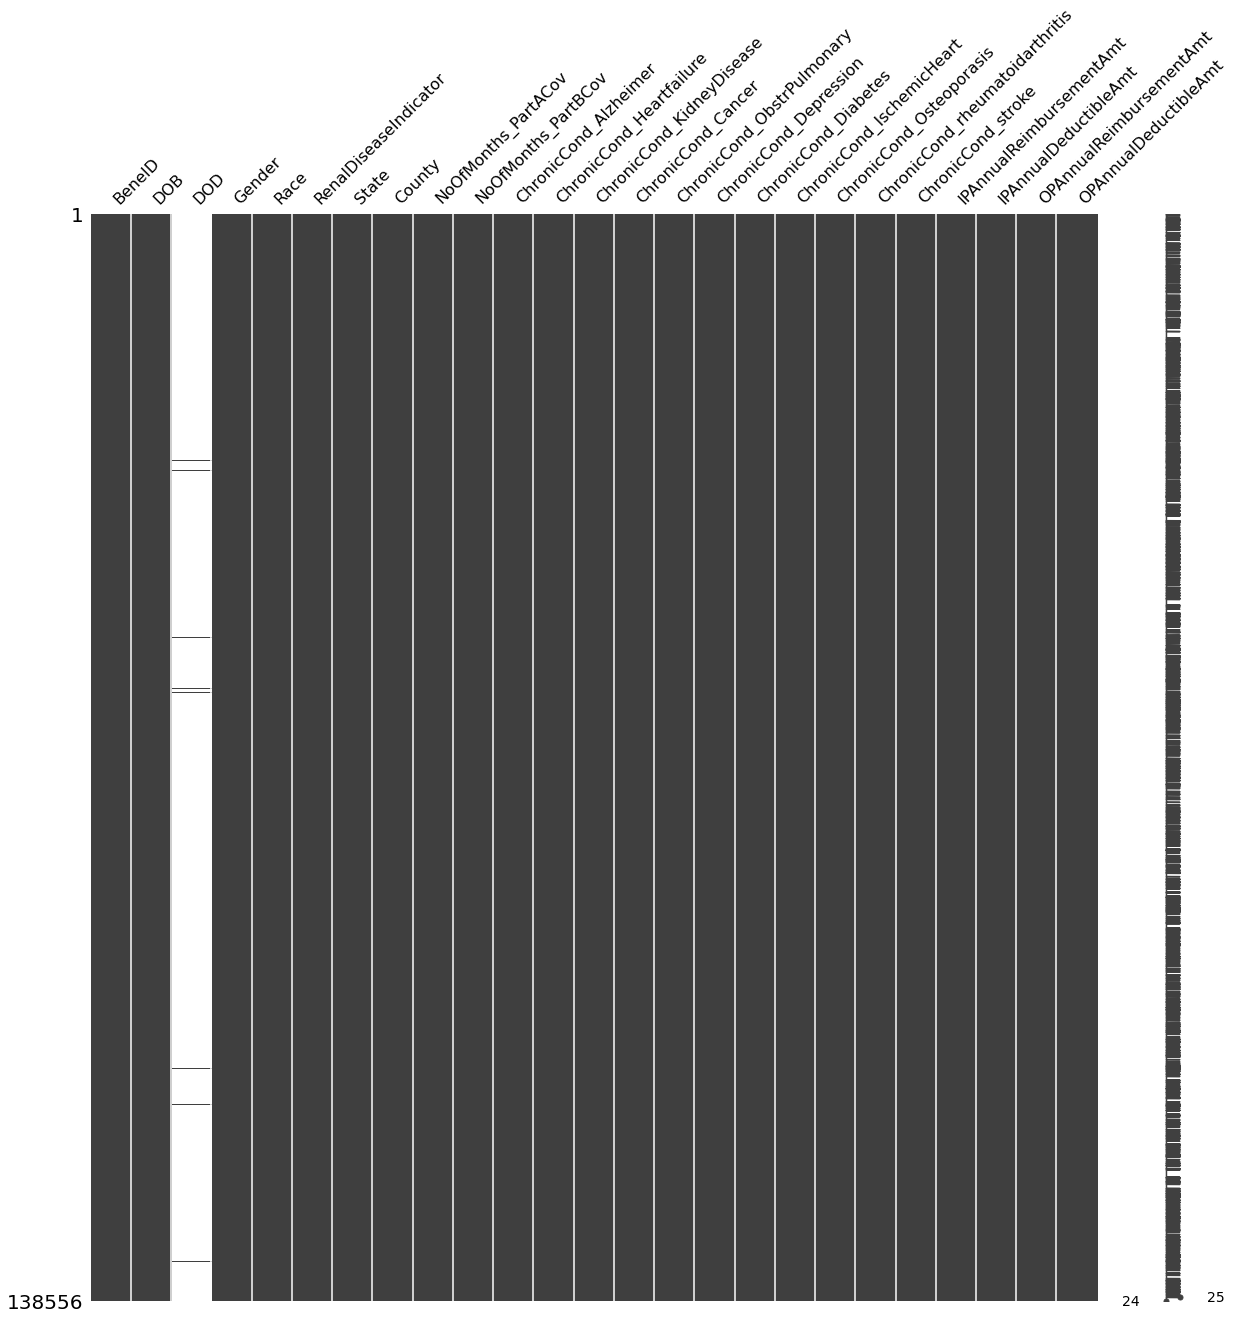

In [25]:
missing = data_dict['Train_Beneficiarydata'].isna().sum(axis=0).sort_values(ascending=False)
print("Missing Features & Count\n",missing[missing!=0])
fig = msno.matrix(data_dict['Train_Beneficiarydata'], figsize=(20,20))
fig_copy = fig.get_figure()
fig_copy.savefig('./graphics/missing_bene.png')
fig

Missing Features & Count
 ClmProcedureCode_6     40474
ClmProcedureCode_5     40465
ClmProcedureCode_4     40358
ClmProcedureCode_3     39509
ClmDiagnosisCode_10    36547
OtherPhysician         35784
ClmProcedureCode_2     35020
ClmProcedureCode_1     17326
OperatingPhysician     16644
ClmDiagnosisCode_9     13497
ClmDiagnosisCode_8      9942
ClmDiagnosisCode_7      7258
ClmDiagnosisCode_6      4838
ClmDiagnosisCode_5      2894
ClmDiagnosisCode_4      1534
DeductibleAmtPaid        899
ClmDiagnosisCode_3       676
ClmDiagnosisCode_2       226
AttendingPhysician       112
dtype: int64


<AxesSubplot:>

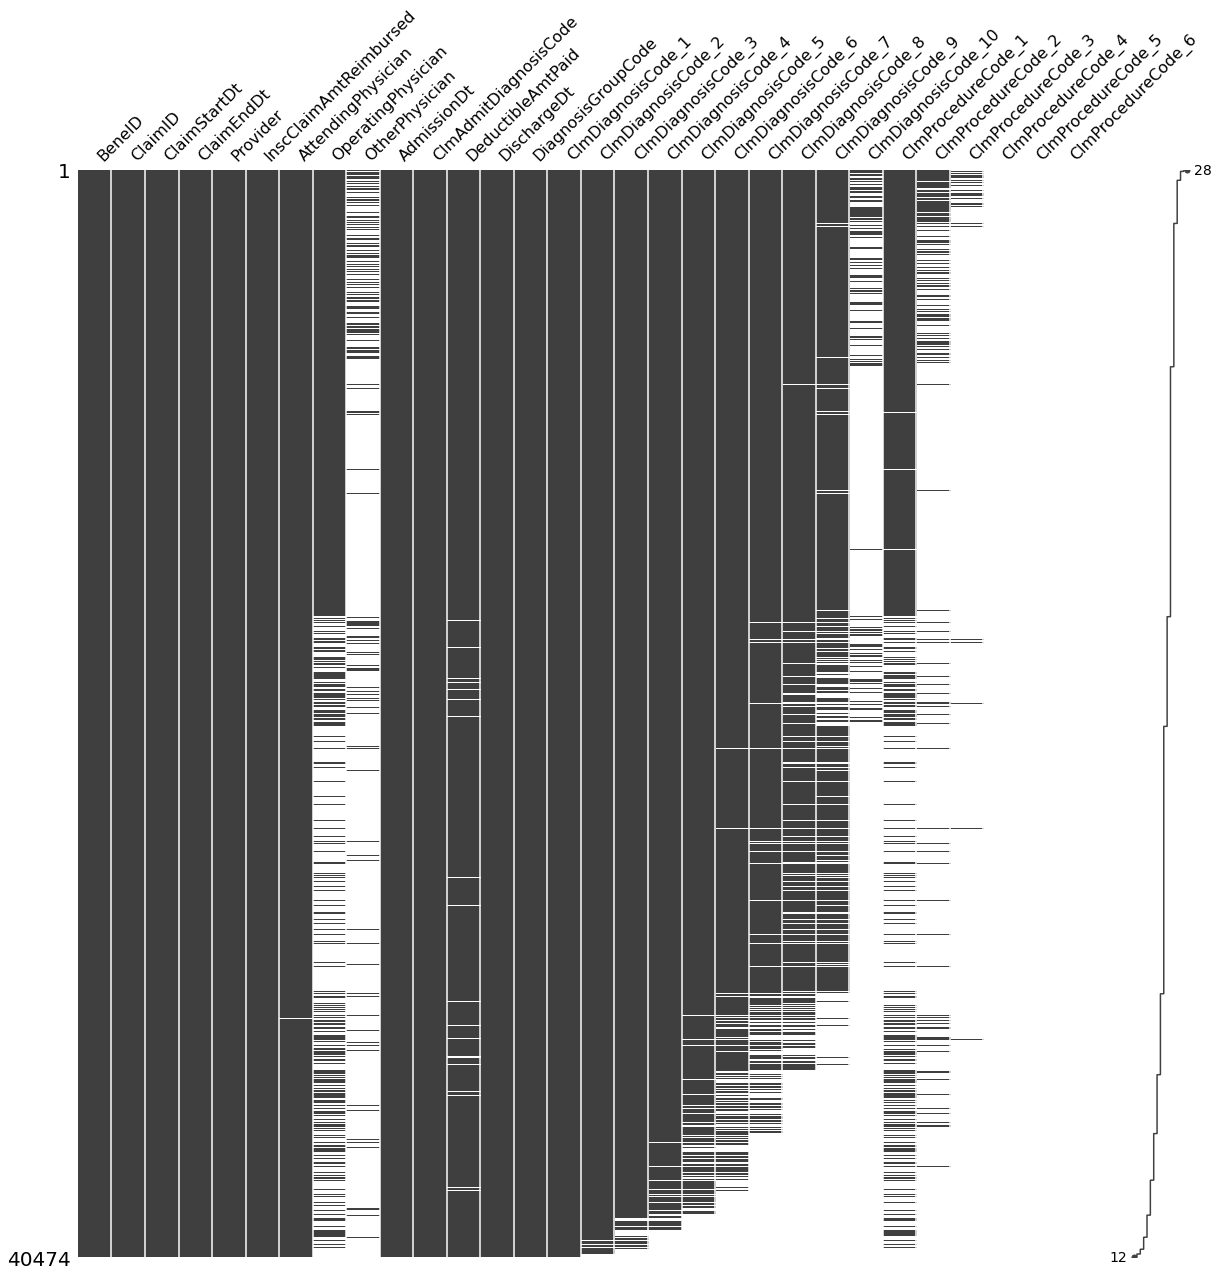

In [27]:
missing = data_dict['Train_Inpatientdata'].isna().sum(axis=0).sort_values(ascending=False)
print("Missing Features & Count\n",missing[missing!=0])
fig = msno.matrix(msno.nullity_sort(data_dict['Train_Inpatientdata'],sort='descending'), figsize=(20,20))
fig_copy = fig.get_figure()
fig_copy.savefig('./graphics/missing_inpat.png')
fig

Missing Features & Count
 ClmProcedureCode_6       517737
ClmProcedureCode_5       517737
ClmProcedureCode_4       517735
ClmProcedureCode_3       517733
ClmProcedureCode_2       517701
ClmProcedureCode_1       517575
ClmDiagnosisCode_10      516654
ClmDiagnosisCode_9       502899
ClmDiagnosisCode_8       494825
ClmDiagnosisCode_7       484776
ClmDiagnosisCode_6       468981
ClmDiagnosisCode_5       443393
OperatingPhysician       427120
ClmAdmitDiagnosisCode    412312
ClmDiagnosisCode_4       392141
OtherPhysician           322691
ClmDiagnosisCode_3       314480
ClmDiagnosisCode_2       195380
ClmDiagnosisCode_1        10453
AttendingPhysician         1396
dtype: int64


<AxesSubplot:>

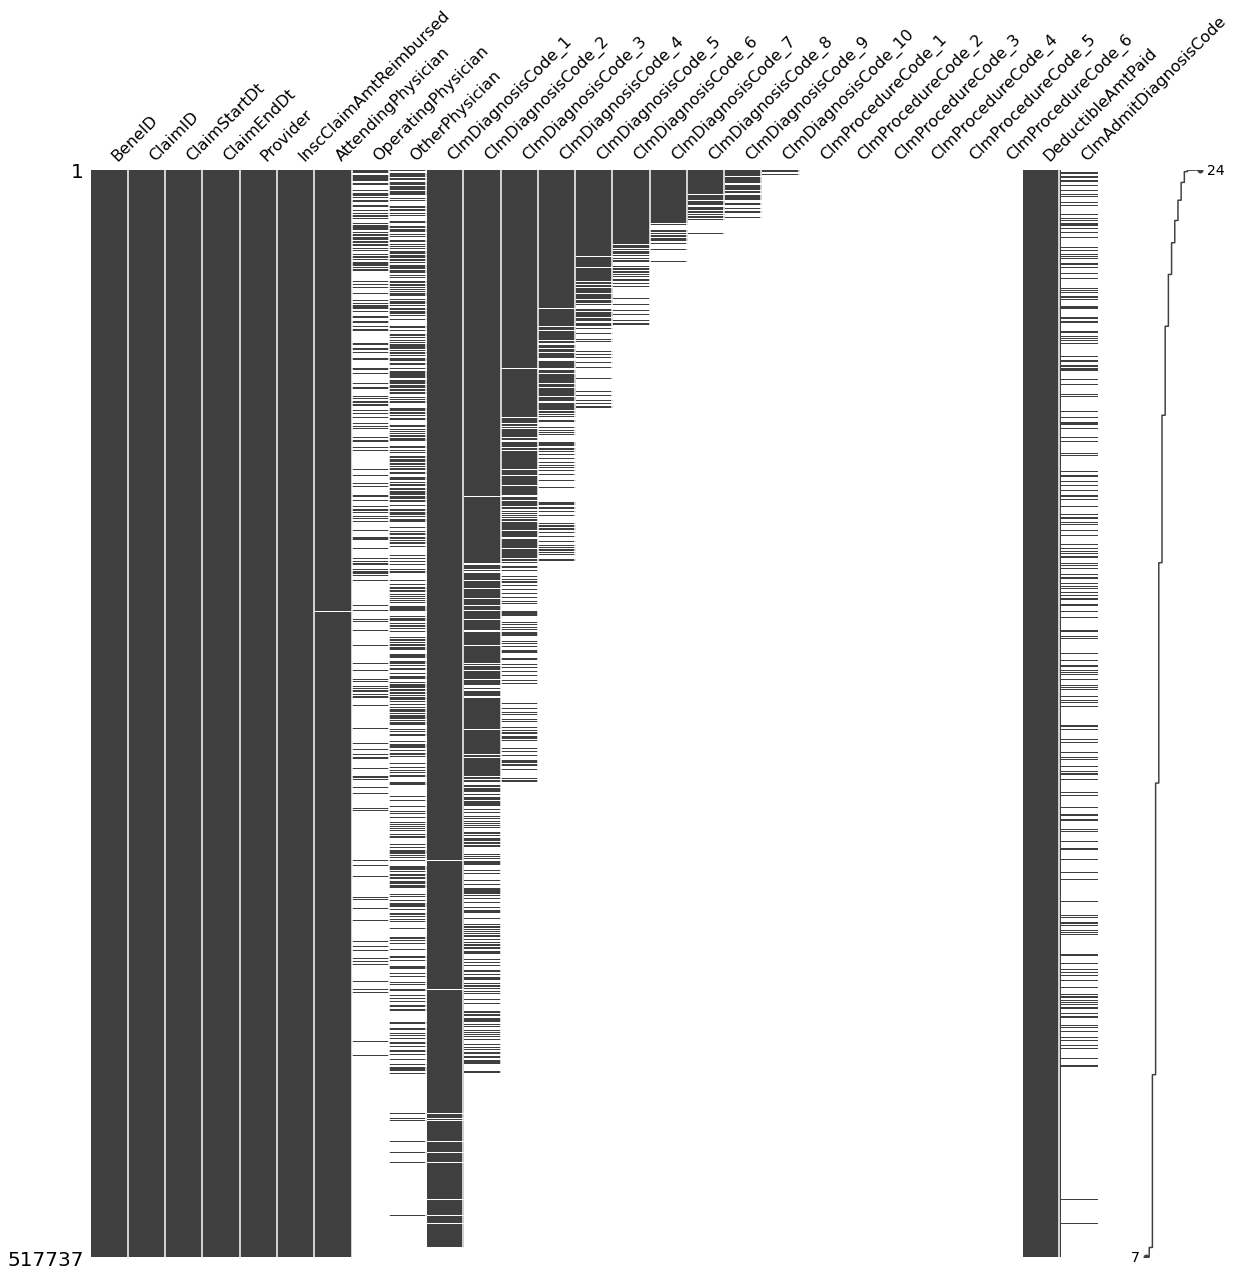

In [30]:
missing = data_dict['Train_Outpatientdata'].isna().sum(axis=0).sort_values(ascending=False)
print("Missing Features & Count\n",missing[missing!=0])
fig = msno.matrix(msno.nullity_sort(data_dict['Train_Outpatientdata'],sort='descending'), figsize=(20,20))
fig_copy = fig.get_figure()
fig_copy.savefig('./graphics/missing_outpat.png')
fig

#### Does Missing DeductableAmtPaid predict Fraud?


In [139]:
data = claims[claims.DeductibleAmtPaid.isna()]

print("Whole Dataset Fraud Rate: {:.2f}".format(claims.PotentialFraud.mean()))
print("Missing Deductable Fraud Rate: {:.2f}".format(data.PotentialFraud.mean()))

Whole Dataset Fraud Rate: 0.38
Missing Deductable Fraud Rate: 0.57


Provider Data

In [10]:
print("Provider Key Information")
print("-"*30)
print("Number of unique Providers: {}\n".format(prov_key.Provider.nunique()))
print("Fraud counts: \n{}\n".format(prov_key.PotentialFraud.value_counts()))
fraud_counts = data_dict['Train'].PotentialFraud.value_counts()[1]
print("Percent Potential Fraud: {:.3}\n".format(100* fraud_counts/ prov_key.PotentialFraud.count()))

prov_key.head()

Provider Key Information
------------------------------
Number of unique Providers: 5410

Fraud counts: 
0    4904
1     506
Name: PotentialFraud, dtype: int64

Percent Potential Fraud: 9.35



## Fraudulent providers are overrepresented in claims data <a id='fraud'></a>

In [51]:
print("Percent Suspect claims\n",100*claims.PotentialFraud.value_counts()/claims.shape[0])
print("Percent Suspect Providers\n",100*data_dict['Train'].PotentialFraud.value_counts()/data_dict['Train'].shape[0])


Percent Suspect claims
 0    61.878931
1    38.121069
Name: PotentialFraud, dtype: float64
Percent Suspect Providers
 No     90.64695
Yes     9.35305
Name: PotentialFraud, dtype: float64


<ipython-input-98-20bcce93e3f3>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(["{}%".format(x) for x in range(0,70,10)])


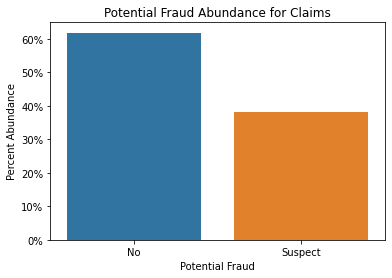

In [98]:
perc_claims    = pd.DataFrame(claims.PotentialFraud.value_counts()/claims.shape[0])
perc_providers = pd.DataFrame(data_dict['Train'].PotentialFraud.value_counts()/data_dict['Train'].shape[0])

plot = sns.barplot(x = perc_claims.index.values, y = perc_claims.PotentialFraud)

plot.set_yticklabels(["{}%".format(x) for x in range(0,70,10)])
plot.set_xticklabels(["No","Suspect"])
plot.set_ylabel("Percent Abundance")
plot.set_xlabel("Potential Fraud")
plot.set_title("Potential Fraud Abundance for Claims")

plt.savefig("./graphics/perc_claims.png")


<ipython-input-83-bd2ce8688ce7>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot2.set_yticklabels(["{}%".format(x) for x in range(0,90,20)])


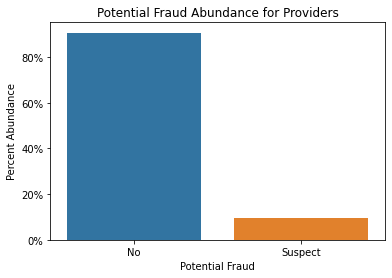

In [83]:
plot2 = sns.barplot(x = perc_providers.index.values, y = perc_providers.PotentialFraud)

plot2.set_yticklabels(["{}%".format(x) for x in range(0,90,20)])
plot2.set_xticklabels(["No","Suspect"])
plot2.set_ylabel("Percent Abundance")
plot2.set_xlabel("Potential Fraud")
plot2.set_title("Potential Fraud Abundance for Providers")

plt.savefig('./graphics/perc_providers.png')

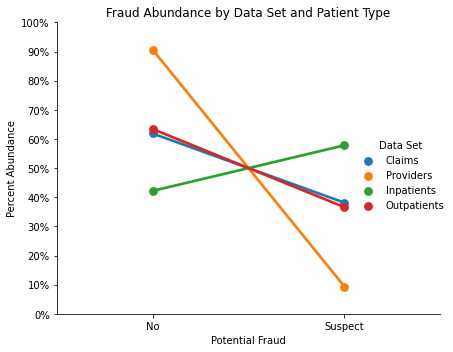

In [32]:
perc_claims    = pd.DataFrame(claims.PotentialFraud.value_counts()/claims.shape[0])
perc_providers = pd.DataFrame(data_dict['Train'].PotentialFraud.value_counts()/data_dict['Train'].shape[0])
perc_inpat     = pd.DataFrame(claims[claims.Source =='Inpatient'].PotentialFraud.value_counts()/claims[claims.Source =='Inpatient'].shape[0])
perc_outpat    = pd.DataFrame(claims[claims.Source =='Outpatient'].PotentialFraud.value_counts()/claims[claims.Source =='Outpatient'].shape[0])

    
fraudulent = pd.DataFrame()
for x,name in zip([perc_claims, perc_providers, perc_inpat, perc_outpat],['Claims',"Providers",'Inpatients','Outpatients']):
    
    fraudulent = fraudulent.append(pd.concat([x.reset_index(),pd.Series([name,name])],axis=1))
    
fraudulent = fraudulent.replace({"No":0,"Yes":1})
fraudulent.columns = ["Potential Fraud","Percent Abundance","Data Set"]

plot = sns.catplot(data = fraudulent, x = 'Potential Fraud', y='Percent Abundance', hue='Data Set',kind ="point")
plot.set_yticklabels(["{}%".format(x) for x in range(0,101,10)])
plot.set_xticklabels(["No","Suspect"])

plt.title("Fraud Abundance by Data Set and Patient Type")
plt.tight_layout()

plt.savefig("./graphics/perc_abundace_all.png")

<ipython-input-40-57da2238a307>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(["{}%".format(x) for x in range(0,101,20)])


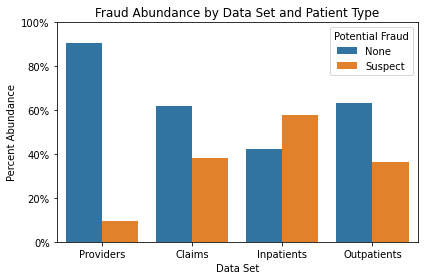

In [40]:
fraudulent['Potential Fraud'] = fraudulent["Potential Fraud"].replace({0:"None",1:"Suspect"})
plot = sns.barplot(x='Data Set',y="Percent Abundance", hue='Potential Fraud', data = fraudulent, order = ["Providers","Claims","Inpatients","Outpatients"])
plt.ylim(0,1)
plot.set_yticklabels(["{}%".format(x) for x in range(0,101,20)])

plt.title("Fraud Abundance by Data Set and Patient Type")
plt.tight_layout()

plt.savefig("./graphics/perc_abundace_all_alt.png")

## Significantly different?

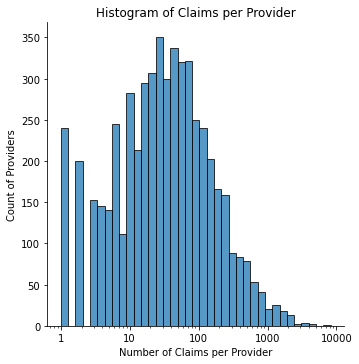

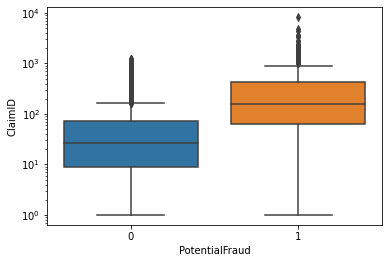

In [129]:
data = claims.groupby('Provider').agg({'ClaimID':'count',"PotentialFraud":"mean"})
sns.displot(data = data, x="ClaimID", log_scale=True)
xticks= [1,10,100,1000,10000]
plt.xticks(ticks = xticks,labels=xticks)
plt.xlabel("Number of Claims per Provider")
plt.ylabel('Count of Providers')
plt.title("Histogram of Claims per Provider")
plt.show()


sns.boxplot(y='ClaimID',x="PotentialFraud",data=data)
plt.yscale('log')



## Race & Gender EDA  <a id='race_gender'></a>

Doesn't make sense to assign providers suspect for choosing to treat specific people. It should be their actions not the people they are affecting.

The downside of this approach is these people are being taken advantage of by fraudulant providers, are may not be getting the treatment they deserve. What makes dropping these variables appropriate in this case is that the quality of care should be handled by a different data set (quality of care is not the same as fraud). Additionally, the government through medicare is making most of these payments, not the people at risk. Since the burden is not directly on the patients, there seems little reason to penalize the provider based on the race or gender of the patient. 

        PotentialFraud    BeneID
Gender                          
1             0.381472  0.429068
2             0.381020  0.570932


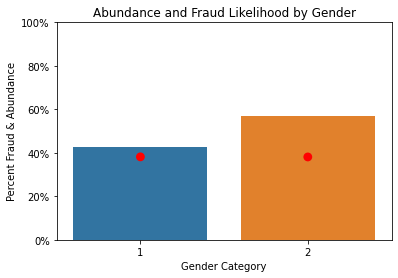

In [56]:
data = claims.groupby('Gender').agg({"PotentialFraud":'mean',"BeneID":'nunique'})
data.BeneID = data.BeneID / data.BeneID.sum()
sns.barplot(x=data.index, y=data.BeneID,zorder=0)
sns.pointplot(x=data.index, y=data.PotentialFraud,linestyles="",color='r',zorder=2)
plt.ylim(0,1)
#plt.axhline(y=claims.PotentialFraud.mean(),c='k')
plt.ylabel("Percent Fraud & Abundance")
plt.xlabel("Gender Category")
yticks=range(0,101,20)
plt.yticks(ticks= [y/100 for y in yticks], labels= ["{}%".format(y) for y in yticks])
print(data)
plt.title("Abundance and Fraud Likelihood by Gender")

plt.savefig('./graphics/gender_eda.png')

      PotentialFraud    BeneID
Race                          
1           0.378623  0.844835
2           0.364558  0.097708
3           0.454578  0.036512
5           0.440355  0.020945


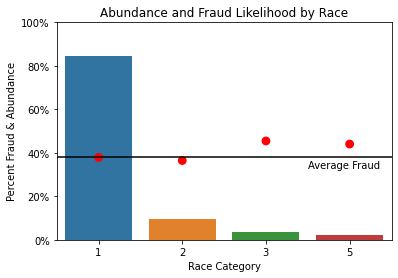

In [57]:
data = claims.groupby('Race').agg({"PotentialFraud":'mean',"BeneID":'nunique'})
data.BeneID = data.BeneID / data.BeneID.sum()
sns.barplot(x=data.index, y=data.BeneID,zorder=0)
sns.pointplot(x=data.index, y=data.PotentialFraud,linestyles="",color='r',zorder=2)
plt.ylim(0,1)
plt.axhline(y=claims.PotentialFraud.mean(),c='k')
plt.text(x=2.5, y=0.33,s="Average Fraud")
plt.ylabel("Percent Fraud & Abundance")
plt.xlabel("Race Category")
yticks=range(0,101,20)
plt.yticks(ticks= [y/100 for y in yticks], labels= ["{}%".format(y) for y in yticks])
plt.title("Abundance and Fraud Likelihood by Race")

print(data)
plt.savefig('./graphics/race_eda.png')

## Data Description

In [84]:
print("Beneficiary Data")
print(data_dict['Train_Beneficiarydata'].shape)
print("-"*30)
print("Number of unique Beneficiary ID: {}\n".format(data_dict['Train_Beneficiarydata'].BeneID.nunique()))
print( "Most columns are condition flags: \n{}".format(data_dict['Train_Beneficiarydata'].columns.values))

Beneficiary Data
(138556, 25)
------------------------------
Number of unique Beneficiary ID: 138556

Most columns are condition flags: 
['BeneID' 'DOB' 'DOD' 'Gender' 'Race' 'RenalDiseaseIndicator' 'State'
 'County' 'NoOfMonths_PartACov' 'NoOfMonths_PartBCov'
 'ChronicCond_Alzheimer' 'ChronicCond_Heartfailure'
 'ChronicCond_KidneyDisease' 'ChronicCond_Cancer'
 'ChronicCond_ObstrPulmonary' 'ChronicCond_Depression'
 'ChronicCond_Diabetes' 'ChronicCond_IschemicHeart'
 'ChronicCond_Osteoporasis' 'ChronicCond_rheumatoidarthritis'
 'ChronicCond_stroke' 'IPAnnualReimbursementAmt' 'IPAnnualDeductibleAmt'
 'OPAnnualReimbursementAmt' 'OPAnnualDeductibleAmt']


In [86]:
print("Inpatient Data")
print(data_dict['Train_Inpatientdata'].shape)
print("-"*30)
print("Number of unique ClaimID ID: {}\n".format(data_dict['Train_Inpatientdata'].ClaimID.nunique()))
print("Most columns are diagnosis, not pivoted, flags: \n{}".format(data_dict['Train_Inpatientdata'].columns.values))

Inpatient Data
(40474, 31)
------------------------------
Number of unique ClaimID ID: 40474

Most columns are diagnosis, not pivoted, flags: 
['BeneID' 'ClaimID' 'ClaimStartDt' 'ClaimEndDt' 'Provider'
 'InscClaimAmtReimbursed' 'AttendingPhysician' 'OperatingPhysician'
 'OtherPhysician' 'AdmissionDt' 'ClmAdmitDiagnosisCode'
 'DeductibleAmtPaid' 'DischargeDt' 'DiagnosisGroupCode'
 'ClmDiagnosisCode_1' 'ClmDiagnosisCode_2' 'ClmDiagnosisCode_3'
 'ClmDiagnosisCode_4' 'ClmDiagnosisCode_5' 'ClmDiagnosisCode_6'
 'ClmDiagnosisCode_7' 'ClmDiagnosisCode_8' 'ClmDiagnosisCode_9'
 'ClmDiagnosisCode_10' 'ClmProcedureCode_1' 'ClmProcedureCode_2'
 'ClmProcedureCode_3' 'ClmProcedureCode_4' 'ClmProcedureCode_5'
 'ClmProcedureCode_6' 'Source']


In [4]:
print("Outpatient Data")
print(data_dict['Train_Outpatientdata'].shape)
print("-"*30)
print("Number of unique ClaimID ID: {}\n".format(data_dict['Train_Outpatientdata'].ClaimID.nunique()))
print("Most columns are diagnosis, not pivoted, flags: \n{}".format(data_dict['Train_Outpatientdata'].columns.values))

Outpatient Data
(517737, 27)
------------------------------
Number of unique ClaimID ID: 517737

Most columns are diagnosis, not pivoted, flags: 
['BeneID' 'ClaimID' 'ClaimStartDt' 'ClaimEndDt' 'Provider'
 'InscClaimAmtReimbursed' 'AttendingPhysician' 'OperatingPhysician'
 'OtherPhysician' 'ClmDiagnosisCode_1' 'ClmDiagnosisCode_2'
 'ClmDiagnosisCode_3' 'ClmDiagnosisCode_4' 'ClmDiagnosisCode_5'
 'ClmDiagnosisCode_6' 'ClmDiagnosisCode_7' 'ClmDiagnosisCode_8'
 'ClmDiagnosisCode_9' 'ClmDiagnosisCode_10' 'ClmProcedureCode_1'
 'ClmProcedureCode_2' 'ClmProcedureCode_3' 'ClmProcedureCode_4'
 'ClmProcedureCode_5' 'ClmProcedureCode_6' 'DeductibleAmtPaid'
 'ClmAdmitDiagnosisCode']


Since inpatent and outpatient are mostly the same, we should determine if they are suitable to be combined.

In [89]:
inpat = set(data_dict['Train_Inpatientdata'].columns.values)
outpat = set(data_dict['Train_Outpatientdata'].columns.values)
print("Columns in Inpatient, not in Outpatient: {}".format(inpat.symmetric_difference(outpat)))

Columns in Inpatient, not in Outpatient: {'DischargeDt', 'DiagnosisGroupCode', 'AdmissionDt'}


In [3]:
dfs = [data_dict['Train_Inpatientdata'],data_dict['Train_Outpatientdata']]
keys = ['Inpatient',"Outpatient"]
Train_Patientdata = pd.concat([df.assign(Source=key).reset_index() for key, df in zip(keys,dfs)],axis=0, ignore_index=True).drop('index',axis=1)
Train_Patientdata.Source.value_counts()

Outpatient    517737
Inpatient      40474
Name: Source, dtype: int64

## Diagnosis & Procedure Codes <a id='codes'></a>

What do DiagnosisCodes look like? Are there different codes between Inpatient and outpatient?

In [5]:
inpatient_diag_codes = set(Train_Patientdata \
                                 .loc[Train_Patientdata['Source']=='Inpatient'] \
                                 .filter(like = 'ClmDiagnosisCode_') \
                                 .astype(str).to_numpy().flatten())
outpatient_diag_codes = set(Train_Patientdata \
                                  .loc[Train_Patientdata['Source']=='Outpatient'] \
                                  .filter(like = 'ClmDiagnosisCode_') \
                                  .astype(str).to_numpy().flatten())

print("There are {} unique diagnositic codes across both sets including NA" \
      .format(len(inpatient_diag_codes.union(outpatient_diag_codes))))

print("There are {} total inpatient diagnositic codes including NA." \
      .format(len(inpatient_diag_codes)))
print("There are {} total outpatient diagnositic codes including NA." \
      .format(len(outpatient_diag_codes)))



print("There are {} codes unique to Inpatient" \
      .format(len(inpatient_diag_codes.difference(outpatient_diag_codes))))
print("There are {} codes unique to Outpatient" \
      .format(len(outpatient_diag_codes.difference(inpatient_diag_codes))))
print("There are {} shared codes" \
      .format(len(outpatient_diag_codes.intersection(inpatient_diag_codes))))


There are 11015 unique diagnositic codes across both sets including NA
There are 4717 total inpatient diagnositic codes including NA.
There are 10847 total outpatient diagnositic codes including NA.
There are 168 codes unique to Inpatient
There are 6298 codes unique to Outpatient
There are 4549 shared codes


In [33]:
inpatient_proced_codes = set(Train_Patientdata \
                                 .loc[Train_Patientdata['Source']=='Inpatient'] \
                                 .filter(like = 'ClmProcedureCode') \
                                 .astype(str).to_numpy().flatten())
outpatient_proced_codes = set(Train_Patientdata \
                                  .loc[Train_Patientdata['Source']=='Outpatient'] \
                                  .filter(like = 'ClmProcedureCode') \
                                  .astype(str).to_numpy().flatten())

print("There are {} unique Procedure codes across both sets including NA" \
      .format(len(inpatient_proced_codes.union(outpatient_proced_codes))))

print("There are {} total inpatient Procedure codes including NA." \
      .format(len(inpatient_proced_codes)))
print("There are {} total outpatient Procedure codes including NA." \
      .format(len(outpatient_proced_codes)))



print("There are {} codes unique to Inpatient" \
      .format(len(inpatient_proced_codes.difference(outpatient_proced_codes))))
print("There are {} codes unique to Outpatient" \
      .format(len(outpatient_proced_codes.difference(inpatient_proced_codes))))
print("There are {} shared codes" \
      .format(len(outpatient_proced_codes.intersection(inpatient_proced_codes))))

There are 1325 unique Procedure codes across both sets including NA
There are 1322 total inpatient Procedure codes including NA.
There are 105 total outpatient Procedure codes including NA.
There are 1220 codes unique to Inpatient
There are 3 codes unique to Outpatient
There are 102 shared codes


Inpatients claims show a linear increase from 0 to 10 diagnositic codes, there appears to be an extremely large discontinutity at 9 diagnositc codes. Perhaps this has to do with the data collection method?

Most inpatient claims have 0-2 procedure codes, almost all outpatient claims have 0, which is expected given that they are outpatients.

Note: There are an order of magnitude more outpatient claims than inpatient claims.

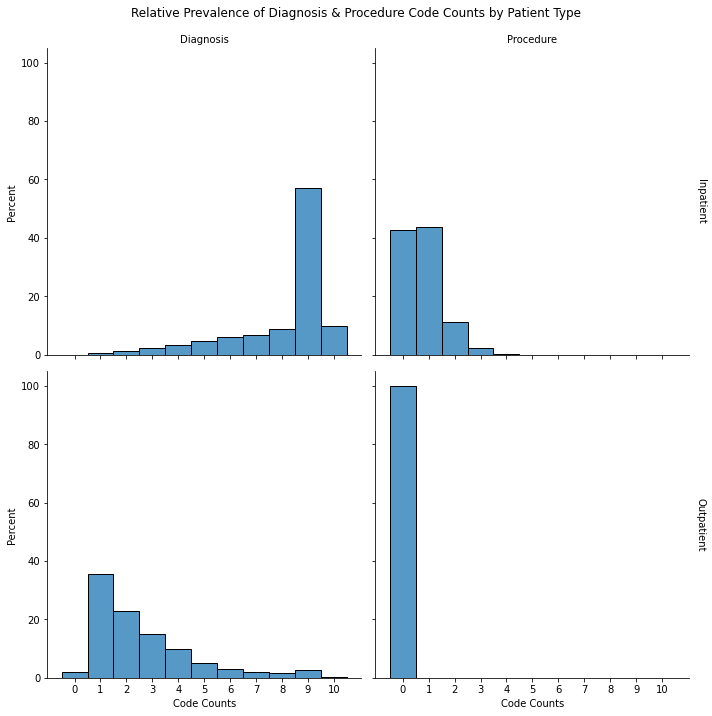

In [5]:
data = Train_Patientdata

data['Diagnosis'] = data.filter(like='ClmDiagnosis').count(axis=1)
data['Procedure'] = data.filter(like='Procedure').count(axis=1)

data = pd.melt(data, id_vars=['Source'],
               value_vars=['Diagnosis','Procedure'],
               value_name='Code Counts',var_name='Code Type')

p = sns.displot(data = data,
           x = 'Code Counts',
           col = 'Code Type',
           row = 'Source',
           kind = 'hist',
            discrete= True,
           facet_kws = dict(sharey=True,margin_titles=True),
               stat='percent',
                common_norm =False
               )

p.set_titles(col_template="{col_name}", row_template='{row_name}')
p.set(xticks=range(0,11))
p.fig.suptitle("Relative Prevalence of Diagnosis & Procedure Code Counts by Patient Type", y=.99)
p.tight_layout()

p.savefig('./graphics/diag_proced_codecounts.png')

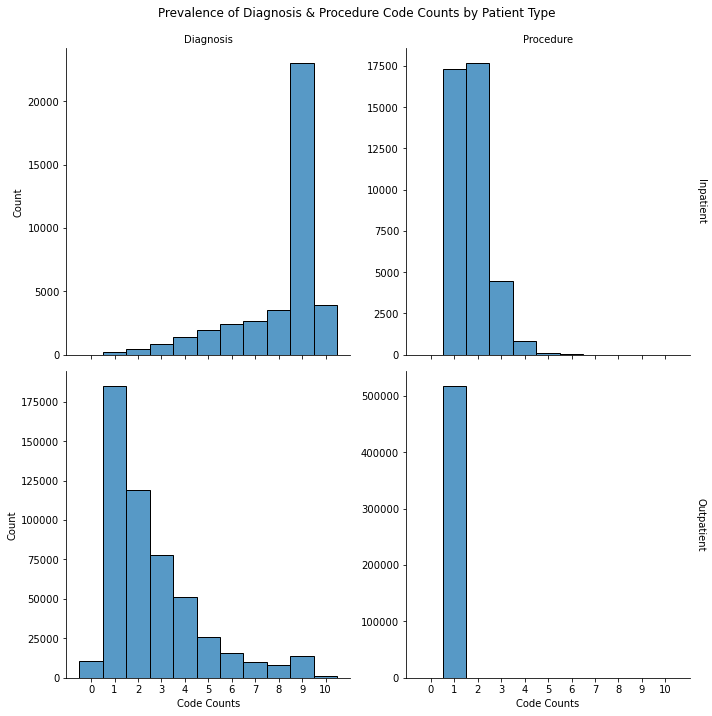

In [90]:
data = Train_Patientdata

data['Diagnosis'] = data.filter(like='ClmDiagnosis').count(axis=1)
data['Procedure'] = data.filter(like='Procedure').count(axis=1)

data = pd.melt(data, id_vars=['Source'],
               value_vars=['Diagnosis','Procedure'],
               value_name='Code Counts',var_name='Code Type')

p = sns.displot(data = data,
           x = 'Code Counts',
           col = 'Code Type',
           row = 'Source',
           kind = 'hist',
            discrete= True,
           facet_kws = dict(sharey=False,margin_titles=True),
               stat='count'
               )

p.set_titles(col_template="{col_name}", row_template='{row_name}')
p.set(xticks=range(0,11))
p.fig.suptitle("Prevalence of Diagnosis & Procedure Code Counts by Patient Type", y=.99)
p.tight_layout()

p.savefig('./graphics/diag_proced_codecounts.png')

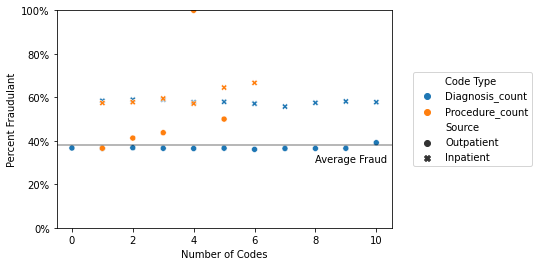

In [86]:
data = claims

data['Diagnosis_count'] = data.filter(like='ClmDiagnosis').count(axis=1)
data['Procedure_count'] = data.filter(like='Procedure').count(axis=1)

data = pd.melt(data,id_vars=['PotentialFraud','Source'],
               value_vars=["Diagnosis_count","Procedure_count"],
              value_name="Number of Codes",var_name='Code Type')

data = data.groupby(['Code Type','Number of Codes','Source']).agg({'PotentialFraud':'mean'}).reset_index()
#print(data.columns)
data

sns.scatterplot(x='Number of Codes',
                y="PotentialFraud",
                data=data,
                hue="Code Type",
                style = 'Source')
plt.axhline(y=claims.PotentialFraud.mean(), c='k',alpha=0.37)
plt.text(x=8,y=.3, s= "Average Fraud")
plt.ylabel("Percent Fraudulant")
plt.xlabel("Number of Codes")
plt.ylim(0,1)
yticks = range(0,101,20)
plt.yticks(ticks = [x/100 for x in yticks],labels=["{}%".format(x) for x in yticks])
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)



#plt.tight_layout()

#plt.savefig("./graphics/.png")



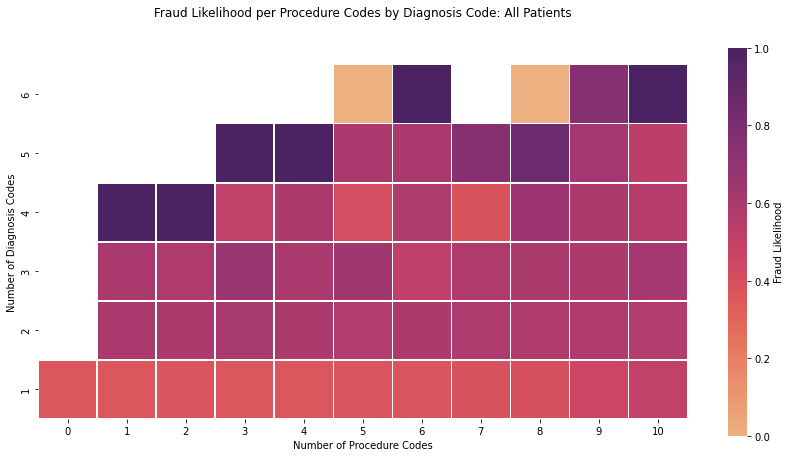

In [85]:
data = claims


data['Diagnosis_count'] = data.filter(like='ClmDiagnosis').count(axis=1)
data['Procedure_count'] = data.filter(like='Procedure').count(axis=1)

diag_proce = data.groupby(["Diagnosis_count","Procedure_count"])\
                 .agg({"PotentialFraud":'mean'}).reset_index()\
                 .pivot(index="Procedure_count",columns='Diagnosis_count',values='PotentialFraud')\
                 .sort_index(ascending=False)



plt.figure(figsize=(12,8))
plot = sns.heatmap(data =diag_proce,
           square=True,
           linewidths=0.5,
           cmap='flare',
           cbar_kws={'shrink':.7, 'label':"Fraud Likelihood"})
plot.set_xlabel("Number of Procedure Codes")
plot.set_ylabel("Number of Diagnosis Codes")
plt.title("Fraud Likelihood per Procedure Codes by Diagnosis Code: All Patients", y= 1.12)
plt.tight_layout()

plt.savefig("./graphics/heatmap_allpat.png")

(40474, 58)


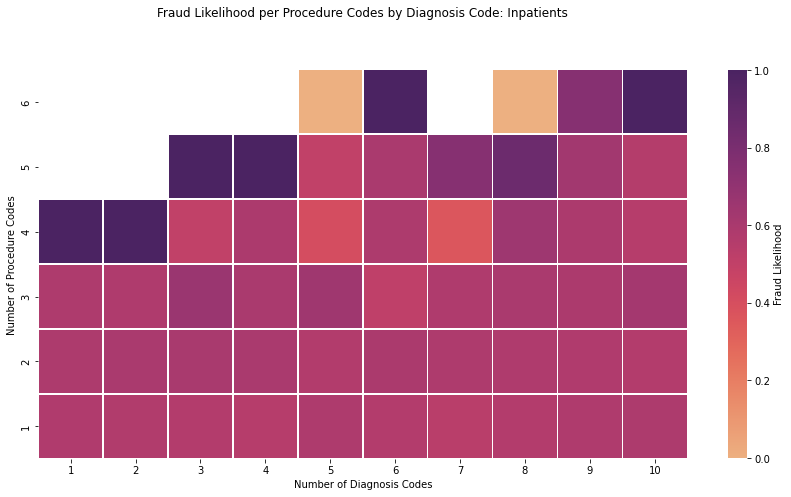

In [84]:
data = claims

data['Diagnosis_count'] = data.filter(like='ClmDiagnosis').count(axis=1)
data['Procedure_count'] = data.filter(like='Procedure').count(axis=1)

diag_proce = data[data.Source == 'Inpatient'].groupby(["Diagnosis_count","Procedure_count"])\
                 .agg({"PotentialFraud":'mean'}).reset_index()\
                 .pivot(index="Procedure_count",columns='Diagnosis_count',values='PotentialFraud')\
                 .sort_index(ascending=False)

print(data[data.Source == 'Inpatient'].shape)

plt.figure(figsize=(12,8))
plot = sns.heatmap(data =diag_proce,
           square=True,
           linewidths=0.5,
           cmap='flare',
           cbar_kws={'shrink':.7, 'label':"Fraud Likelihood"})
plot.set_xlabel("Number of Diagnosis Codes")
plot.set_ylabel("Number of Procedure Codes")
plt.title("Fraud Likelihood per Procedure Codes by Diagnosis Code: Inpatients", y= 1.12)
plt.tight_layout()

plt.savefig("./graphics/heatmap_inpat.png")


(517737, 58)


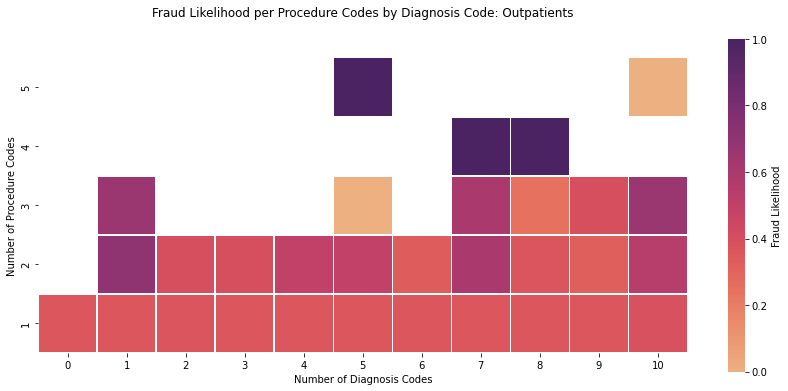

In [83]:
data = claims

data['Diagnosis_count'] = data.filter(like='ClmDiagnosis').count(axis=1)
data['Procedure_count'] = data.filter(like='Procedure').count(axis=1)

diag_proce = data[data.Source == 'Outpatient'].groupby(["Diagnosis_count","Procedure_count"])\
                 .agg({"PotentialFraud":'mean'}).reset_index()\
                 .pivot(index="Procedure_count",columns='Diagnosis_count',values='PotentialFraud')\
                 .sort_index(ascending=False)

print(data[data.Source == 'Outpatient'].shape)

plt.figure(figsize=(12,8))
plot = sns.heatmap(data =diag_proce,
           square=True,
           linewidths=0.5,
           cmap='flare',
           cbar_kws={'shrink':.6, 'label':"Fraud Likelihood"})
plot.set_xlabel("Number of Diagnosis Codes")
plot.set_ylabel("Number of Procedure Codes")
plt.title("Fraud Likelihood per Procedure Codes by Diagnosis Code: Outpatients", y= 1.12)
plt.tight_layout()

plt.savefig("./graphics/heatmap_outpat.png")

#### Procedures per diagnostic code doesnt show much signal.

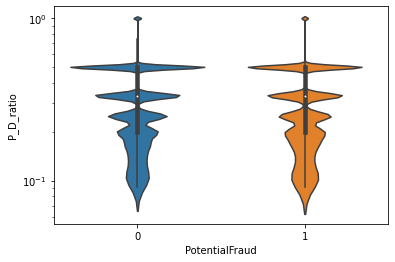

In [174]:
data = claims

data['Diagnosis_count'] = data.filter(like='ClmDiagnosis').count(axis=1)
data['Procedure_count'] = data.filter(like='Procedure').count(axis=1)
data['P_D_ratio']       = (data.Procedure_count / (data.Diagnosis_count+data.Procedure_count))

data.P_D_ratio.value_counts(dropna=False)
sns.violinplot(x="PotentialFraud",y="P_D_ratio",data = data)
plt.yscale('log')

In [37]:
Train_Patientdata["DiagnosisCodeCount"] = Train_Patientdata.filter(like="ClmDiagnosisCode_").count(axis=1)
Train_Patientdata["ProcedureCodeCount"] = Train_Patientdata.filter(like="ClmProcedureCode_").count(axis=1)

array([[<AxesSubplot:title={'center':'n_claims'}>,
        <AxesSubplot:title={'center':'n_provider'}>],
       [<AxesSubplot:title={'center':'avg_reimbursed'}>,
        <AxesSubplot:title={'center':'avg_deductable'}>],
       [<AxesSubplot:title={'center':'avg_diag_count'}>,
        <AxesSubplot:title={'center':'avg_prcd_count'}>]], dtype=object)

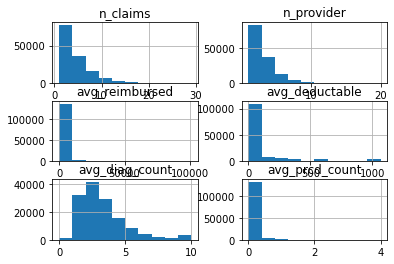

In [46]:
Train_Patientdata.groupby("BeneID").agg(n_claims = ("ClaimID","nunique"),
                                        n_provider = ("Provider","nunique"),
                                        avg_reimbursed = ("InscClaimAmtReimbursed","mean"),
                                        avg_deductable = ("DeductibleAmtPaid","mean"),
                                        avg_diag_count = ("DiagnosisCodeCount",'mean'),
                                        avg_prcd_count = ("ProcedureCodeCount",'mean')
                                       ).hist()

In [4]:
Bene_data = data_dict['Train_Beneficiarydata']

Bene_data.columns

Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt'],
      dtype='object')

In [47]:
print("There are {} patients".format(Bene_data.shape[0]))
print("{:.2f}% of patients have not died".format(100* Bene_data[Bene_data.DOD.isna()].shape[0] / Bene_data.shape[0]))


There are 138556 patients
98.97% of patients have not died


Considering the abundance and data, especially without a data dictionary, 1 appears to be the condition "present" value and 2 is the condition "absent" value. This feels intuitive since only conditions like Diabetes, IschmicHeart (clogged arteries) are more common than absent in the dataset. 

This is also consistant with more rare conditions such as cancer, depression, and ObstrPulmanary, where 2 has a higher count than 1. 

In [103]:
[Bene_data[x].value_counts(dropna=False) for x in Bene_data.filter(like="ChronicCond_").columns]

[2    92530
 1    46026
 Name: ChronicCond_Alzheimer, dtype: int64,
 2    70154
 1    68402
 Name: ChronicCond_Heartfailure, dtype: int64,
 2    95277
 1    43279
 Name: ChronicCond_KidneyDisease, dtype: int64,
 2    121935
 1     16621
 Name: ChronicCond_Cancer, dtype: int64,
 2    105697
 1     32859
 Name: ChronicCond_ObstrPulmonary, dtype: int64,
 2    89296
 1    49260
 Name: ChronicCond_Depression, dtype: int64,
 1    83391
 2    55165
 Name: ChronicCond_Diabetes, dtype: int64,
 1    93644
 2    44912
 Name: ChronicCond_IschemicHeart, dtype: int64,
 2    100497
 1     38059
 Name: ChronicCond_Osteoporasis, dtype: int64,
 2    102972
 1     35584
 Name: ChronicCond_rheumatoidarthritis, dtype: int64,
 2    127602
 1     10954
 Name: ChronicCond_stroke, dtype: int64]

Exploring association rule for chronic conditions

In [22]:
Bene_data.filter(like="ChronicCond_").head()

,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
0,1,2,1,2,2,1,1,1,2,1,1
1,2,2,2,2,2,2,2,2,2,2,2
2,1,2,2,2,2,2,2,1,2,2,2
3,1,1,2,2,2,2,1,1,1,1,2
4,2,2,2,2,1,2,1,2,2,2,2


It might be more useful to make a key of diagnosis/procedures based on chronic conditions and then get the percentage prevalence for the pair.

In [75]:
claim_bene = Train_Patientdata.merge(Bene_data,on="BeneID")
claim_bene.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Source', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', '

In [94]:
filter_cols = ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6','RenalDiseaseIndicator','ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']

renamed_cols = ['RenalDiseaseIndicator','ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']


prevalence_lookup = claim_bene.filter(filter_cols, axis=1)

prevalence_lookup


prevalence_lookup = prevalence_lookup.loc[:,:] \
                             .replace(1,pd.Series(prevalence_lookup.columns, prevalence_lookup.columns)) \
                             .replace(2,np.NaN)

pd.melt()


,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,...,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
0,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,...,NaN,ChronicCond_KidneyDisease,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,NaN,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
1,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,ChronicCond_KidneyDisease,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,NaN,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
2,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,...,NaN,ChronicCond_KidneyDisease,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,NaN,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
3,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,...,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
4,78969,78701,V5866,59389,2449,NaN,NaN,NaN,NaN,NaN,...,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,2163,V4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ChronicCond_Heartfailure,NaN,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,NaN
558207,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ChronicCond_Heartfailure,NaN,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,NaN
558208,V570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ChronicCond_Heartfailure,NaN,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,NaN
558209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ChronicCond_Heartfailure,NaN,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,NaN


# IF YOU are treated by a suspect provider are you more liely to have higher codes?

array([[<AxesSubplot:title={'center':'(0, Inpatient)'}>,
        <AxesSubplot:title={'center':'(0, Outpatient)'}>],
       [<AxesSubplot:title={'center':'(1, Inpatient)'}>,
        <AxesSubplot:title={'center':'(1, Outpatient)'}>]], dtype=object)

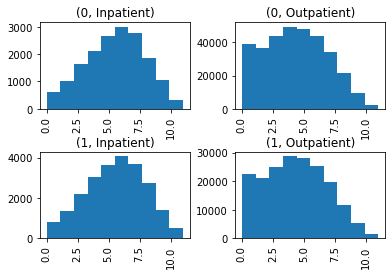

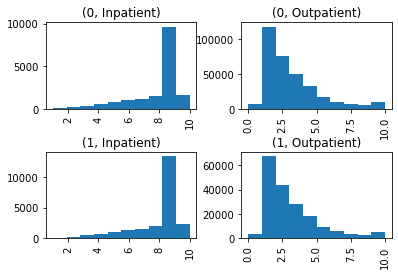

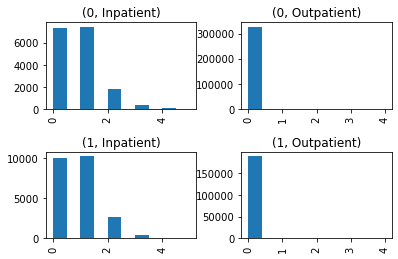

In [56]:
    chronic_cols = ['RenalDiseaseIndicator','ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
                   'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
                   'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
                   'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
                   'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                   'ChronicCond_stroke']

# Count of Chronic conditions
    claims.filter(items = chronic_cols).sum(axis=1).hist(by=[claims.PotentialFraud,claims.Source])
    
    # Count of Diagnosis Codes
    claims.filter(like="ClmDiagnosisCode_").count(axis=1).hist(by=[claims.PotentialFraud,claims.Source])
    
    # Count of Procedure Codes
    claims.filter(like="ClmProcedureCode_").count(axis=1).hist(by=[claims.PotentialFraud,claims.Source])

array([[<AxesSubplot:title={'center':'PotentialFraud'}>]], dtype=object)

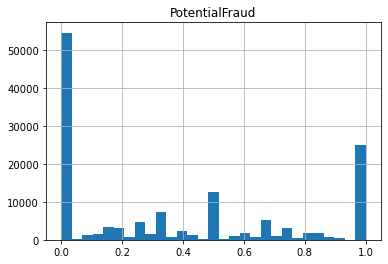

In [72]:
claims.groupby("BeneID").agg({"PotentialFraud":"mean"}).hist(bins=29)

### Claims per Beneficiary

differences between inpat/outpat?

Text(0.5, 1.0, 'Claims per Beneficiary')

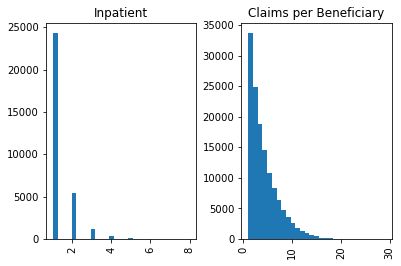

In [7]:
claims.groupby('BeneID').agg({'ClaimID':'count'}).value_counts()

claims.groupby(['BeneID','Source']).agg({'ClaimID':'count'}).hist(by = ['Source',],bins=29,align='mid')
plt.title('Claims per Beneficiary')

(0.0, 1.0)

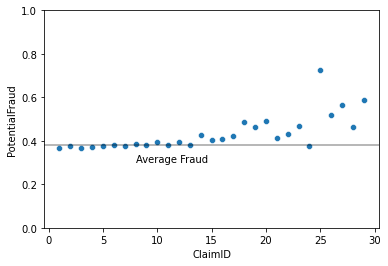

In [67]:
data=claims.groupby(
).agg({'ClaimID':'count','PotentialFraud':"mean"}).groupby('ClaimID').agg({'PotentialFraud':'mean'})

sns.scatterplot(x=data.index,y=data.PotentialFraud)

plt.axhline(y=claims.PotentialFraud.mean(), c='k',alpha=0.37)
plt.text(x=8,y=.3, s= "Average Fraud")
plt.ylim(0,1)



## Physicians per Provider

Index(['value', 'Potentially Fraudlent'], dtype='object')


,Potentially Fraudlent
value,
"(0, 5]",0.027004
"(5, 10]",0.071525
"(10, 25]",0.103152
"(25, 50]",0.161572
"(50, 100]",0.248718
"(100, 200]",0.388889
"(200, 1000]",0.548387


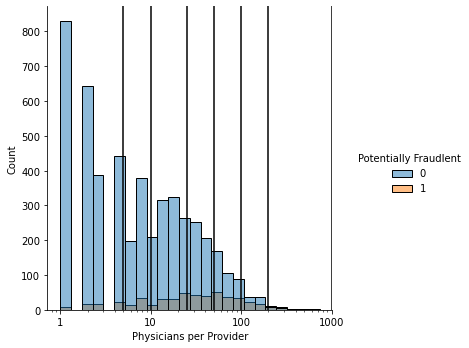

In [51]:
data = claims.melt(id_vars='Provider',value_vars=["AttendingPhysician","OperatingPhysician","OtherPhysician"])\
                .groupby('Provider')\
                .agg({'value':'nunique'})\
                .join(prov_key.set_index('Provider'), on='Provider')\
                .rename({"PotentialFraud":"Potentially Fraudlent"},axis=1)

print(data.columns)
sns.displot(data=data, x='value',log_scale=True,hue='Potentially Fraudlent',)

bins = [0,5,10,25,50,100,200,1000]
data = data.groupby([pd.cut(data.value,bins)]).agg({"Potentially Fraudlent":'mean'})


for bin in bins:
    plt.axvline(bin,c='k')

xticks= [1,10,100,1000]    
plt.xticks(ticks=xticks,labels=xticks)
plt.xlabel("Physicians per Provider")
data


In [145]:
physican_counts = claims.filter(like="Phys").count(axis=1)

print("Does the Number of Physicians per claim predict potential Fraud?")
claims.groupby(physican_counts).agg({'PotentialFraud':'mean'})

Does the Number of Physicians per claim predict potential Fraud?


,PotentialFraud
0,0.372218
1,0.374200
2,0.391054
3,0.376620


#### What is the time spread of multiple claims?

In [61]:
date_dict = ['ClaimStartDt',"ClaimEndDt","AdmissionDt","DischargeDt",'DOB',"DOD"]
claims[date_dict] = claims[date_dict].apply(pd.to_datetime)

days_since_last     = claims.sort_values('ClaimStartDt').groupby('BeneID').ClaimStartDt.diff().dt.days
days_since_last     = days_since_last.replace({np.nan:0})
cummulative_claims  = claims.sort_values('ClaimStartDt').groupby('BeneID').cumcount() +1 #make human readable
patient_prov_claims = claims.sort_values('ClaimStartDt').groupby(['BeneID','Provider']).cumcount() +1 #make human readable

In [62]:
data = claims

data['days_since_last']     = days_since_last
data['cummulative_claims']  = cummulative_claims
data['patient_prov_claims'] = patient_prov_claims

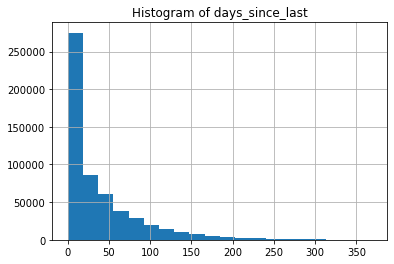

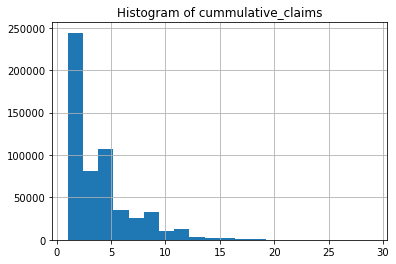

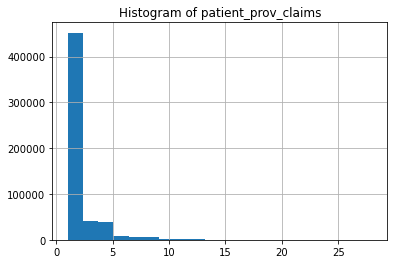

In [64]:
for x in ['days_since_last','cummulative_claims','patient_prov_claims']:
    data[x].hist(bins=20,align='mid')
    plt.title("Histogram of {}".format(x))
    plt.show()

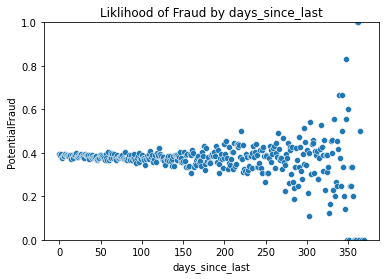

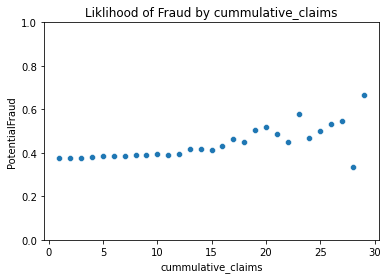

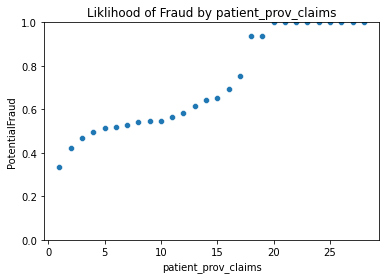

In [64]:
for x in ['days_since_last','cummulative_claims','patient_prov_claims']:
    grouped = data.groupby(x).agg({"PotentialFraud":'mean'})
    sns.scatterplot(x=grouped.index, y=grouped.PotentialFraud)
    plt.title("Liklihood of Fraud by {}".format(x))
    plt.ylim(0,1)
    plt.show()

## Date Analysis <a id='date'></a>

There doesn't seem to be any clear uptick/change in the likelihood of fraud over time. The increase in varaince in DOB data is likely due to a decrease number of beneficiaries, there are fewer younger people making claims, compared to mid-range of age. 

Admission and Discharge have shifted mean Potential Fraud because the mean for inpatient is higher than outpatient and admission/discharge only has data for inpatients. 

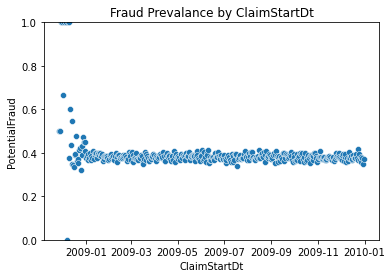

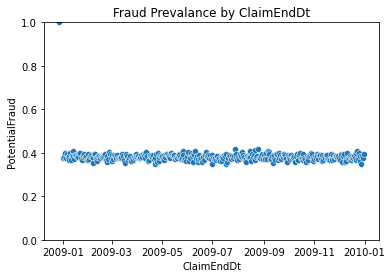

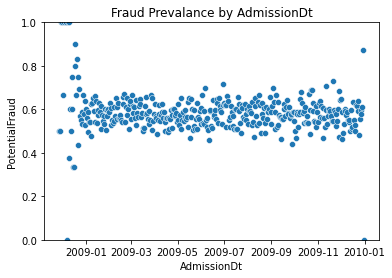

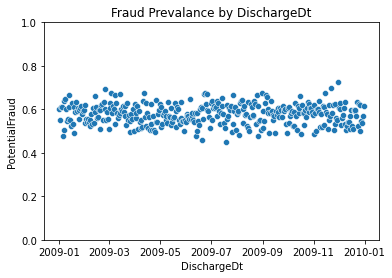

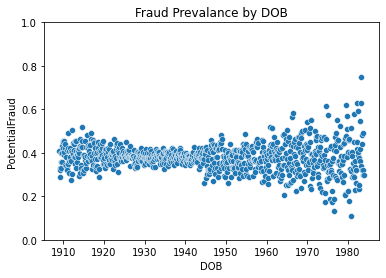

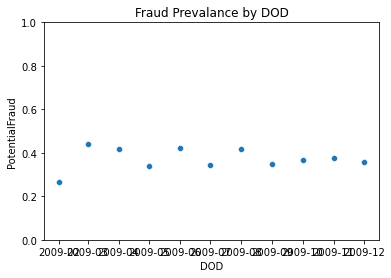

In [204]:
date_dict = ['ClaimStartDt',"ClaimEndDt","AdmissionDt","DischargeDt",'DOB',"DOD"]
claims[date_dict] = claims[date_dict].apply(pd.to_datetime)

for x in date_dict:
    data = claims.groupby(x).agg({"PotentialFraud":"mean"})
    sns.scatterplot(x = data.index,y= data.PotentialFraud)
    plt.ylim(0,1)
    plt.title("Fraud Prevalance by {}".format(x))
    plt.show()

### Some Dates just dont add up.

In [206]:
mask = claims.AdmissionDt.notna()
thing1 = claims[mask][claims[mask]['ClaimStartDt'] != claims[mask]['AdmissionDt']].filter(['ClaimStartDt','ClaimEndDt','AdmissionDt','DischargeDt','PotentialFraud'])  #.filter(['ClaimStartDt','AdmissionDt'])
thing1

,ClaimStartDt,ClaimEndDt,AdmissionDt,DischargeDt,PotentialFraud
62479,2009-02-15,2009-02-20,2009-02-04,2009-02-20,1
65458,2009-11-19,2009-12-06,2009-11-15,2009-12-06,1
82571,2009-09-13,2009-09-20,2009-09-11,2009-09-20,0
124136,2009-03-18,2009-04-08,2009-03-04,2009-04-08,1
170272,2009-04-21,2009-04-30,2009-03-26,2009-04-30,0
175538,2009-11-14,2009-11-17,2009-11-13,2009-11-17,0
190695,2009-07-16,2009-07-17,2009-07-14,2009-07-17,1
198270,2009-02-10,2009-02-11,2009-02-08,2009-02-11,1
210780,2009-04-10,2009-04-11,2009-04-09,2009-04-11,1
227723,2009-10-21,2009-10-22,2009-10-18,2009-10-22,0


In [198]:
mask = claims.DischargeDt.notna()
thing2 = claims[mask][claims[mask]['ClaimEndDt'] != claims[mask]['DischargeDt']]\
                .filter(['ClaimStartDt','ClaimEndDt','AdmissionDt','DischargeDt',
                         'Source','PotentialFraud','ClaimID','BeneID','Provider'])
thing2

,ClaimStartDt,ClaimEndDt,AdmissionDt,DischargeDt,Source,PotentialFraud,ClaimID,BeneID,Provider
18894,2009-01-03,2009-01-29,2009-01-03,2009-01-28,Inpatient,1,CLM82218,BENE119908,PRV57191
41957,2009-01-03,2009-01-12,2009-01-03,2009-01-09,Inpatient,1,CLM82202,BENE11093,PRV51842
62741,2008-12-01,2009-01-06,2008-12-01,2009-01-03,Inpatient,1,CLM82204,BENE156020,PRV52019
65051,2009-01-08,2009-01-12,2009-01-08,2009-01-10,Inpatient,1,CLM82214,BENE138446,PRV54955
65397,2009-02-09,2009-03-17,2009-02-09,2009-03-16,Inpatient,1,CLM82217,BENE110116,PRV56268
77470,2008-12-26,2009-01-04,2008-12-26,2009-01-03,Inpatient,1,CLM82206,BENE116436,PRV52178
141893,2009-02-23,2009-02-28,2009-02-23,2009-02-25,Inpatient,1,CLM82205,BENE88968,PRV52045
215587,2009-01-18,2009-01-27,2009-01-18,2009-01-25,Inpatient,1,CLM82209,BENE44545,PRV52843
268514,2009-01-17,2009-01-25,2009-01-17,2009-01-24,Inpatient,1,CLM82201,BENE131263,PRV51021
276700,2009-01-01,2009-01-22,2009-01-01,2009-01-19,Inpatient,1,CLM82216,BENE107828,PRV55018


## Medicare parts <a id='medicare_part'></a>

There does not seem to be any significant signal in the length of medicare participation for predicting fraud. 

Most Beneficiaries have had medicare for more than 12 months (or coverage for the full year of interest). Those without medicare for the full year do not appear to be more likeliky to visits a fraudulent provider. 

Given this distribution, and lack of signal, these columns are dropped out of modeling. 

<ipython-input-62-5fcb7127cc35>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(labels=["{}%".format(x) for x in yticks])


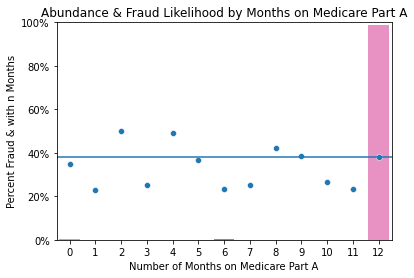

<ipython-input-62-5fcb7127cc35>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(labels=["{}%".format(x) for x in yticks])


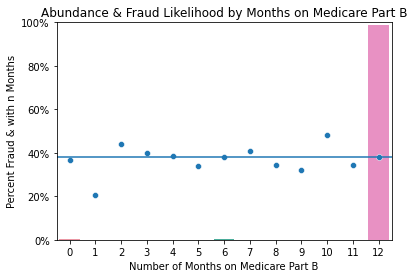

In [62]:
def mediplot(data):
    plot = sns.scatterplot(x=data.index,y= data.PotentialFraud,zorder=1)
    plot = sns.barplot(x=data2.index, y=data2.BeneID/data2.BeneID.sum(),zorder=0)
    plot.axhline(y=claims.PotentialFraud.mean())
    plot.set_ylim(0,1)
    yticks = range(0,101,20)
    plot.set_yticklabels(labels=["{}%".format(x) for x in yticks])
    return plot

data1 = claims.groupby("NoOfMonths_PartACov").agg({'PotentialFraud':'mean','BeneID':'nunique'})
data2 = claims.groupby("NoOfMonths_PartBCov").agg({'PotentialFraud':'mean','BeneID':'nunique'})


partA = mediplot(data1)
partA.set_ylabel("Percent Fraud & with n Months")
partA.set_xlabel("Number of Months on Medicare Part A")
partA.set_title("Abundance & Fraud Likelihood by Months on Medicare Part A")
plt.savefig('./graphics/medicare_partA')
plt.show()

partB = mediplot(data2)
partB.set_ylabel("Percent Fraud & with n Months")
partB.set_xlabel("Number of Months on Medicare Part B")
partB.set_title("Abundance & Fraud Likelihood by Months on Medicare Part B")
plt.savefig('./graphics/medicare_partB')
plt.show()

## State & County <a id='state'></a>

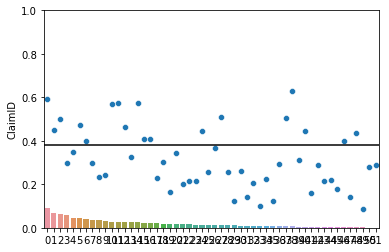

    State  PotentialFraud   ClaimID
0       5        0.590750  0.091990
1      10        0.448187  0.069997
2      33        0.499429  0.062743
3      45        0.297895  0.060948
4      14        0.348487  0.043742
5      39        0.472063  0.043444
6      23        0.400037  0.038235
7      36        0.299704  0.038141
8      34        0.231949  0.033867
9      11        0.242487  0.030460
10     31        0.571644  0.028556
11     49        0.574315  0.026866
12     44        0.465321  0.025829
13     15        0.326110  0.025462
14     22        0.572372  0.024407
15     26        0.410580  0.023129
16     50        0.407325  0.021031
17     21        0.228754  0.020173
18     42        0.303117  0.018794
19     18        0.162662  0.018491
20      1        0.344238  0.018344
21     52        0.199449  0.017542
22      3        0.217252  0.016739
23     19        0.213086  0.014183
24     24        0.446932  0.013841
25      4        0.256901  0.013563
26     16        0.366501  0

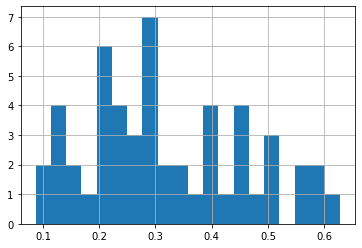

In [60]:
data = claims.groupby('State').agg({"PotentialFraud":"mean",'ClaimID':'count'})
data['ClaimID'] = data['ClaimID']/  data['ClaimID'].sum()
data = data.sort_values('ClaimID', ascending=False).reset_index()
sns.scatterplot(x= data.index, y =data.PotentialFraud, zorder = 1)
sns.barplot(x=data.index, y = data.ClaimID, zorder =2)
plt.ylim(0,1)
plt.axhline(claims.PotentialFraud.mean(),c='k')
plt.show()
data.PotentialFraud.hist(bins=20)
print(data)

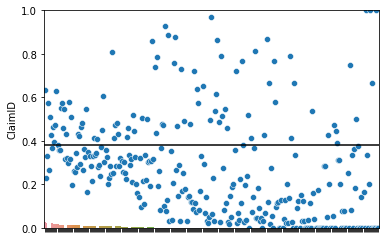

     County  PotentialFraud   ClaimID
0       200        0.631572  0.028586
1        10        0.231154  0.025048
2        20        0.330431  0.022629
3       470        0.574035  0.021995
4        60        0.265194  0.021488
..      ...             ...       ...
309     742        0.000000  0.000004
310     944        0.000000  0.000004
311     834        1.000000  0.000002
312     521        0.000000  0.000002
313     804        0.000000  0.000002

[314 rows x 3 columns]


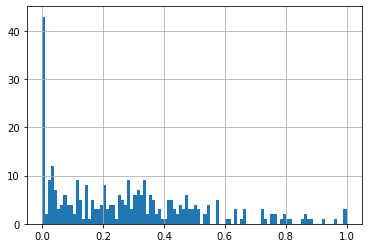

In [61]:
data = claims.groupby('County').agg({"PotentialFraud":"mean",'ClaimID':'count'})
data['ClaimID'] = data['ClaimID']/  data['ClaimID'].sum()
data = data.sort_values('ClaimID', ascending=False).reset_index()
sns.scatterplot(x= data.index, y =data.PotentialFraud, zorder = 1)
sns.barplot(x=data.index, y = data.ClaimID, zorder =2)
plt.ylim(0,1)
plt.axhline(claims.PotentialFraud.mean(),c='k')
plt.xticks(ticks = data.index, labels="")
plt.show()
data.PotentialFraud.hist(bins=100)

print(data)

## Payments <a id="payments"></a>

The annual reimbursement ammounts seem to be derived from the data, but also include information not in the dataset, for example, patient BENE100002 (third in table) has 1 inpatient claim which was reimbursed to the provider for 12,000. However thier Annual Inpatient Reimbursement Amount is 12,250, missing 250 units. 



In [116]:
pays = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt','PotentialFraud', 'BeneID']

claims.groupby(['BeneID','Source','ClaimID'])\
        .agg({"IPAnnualReimbursementAmt":'mean',"OPAnnualReimbursementAmt":'mean',"InscClaimAmtReimbursed":'sum', 'DeductibleAmtPaid':'mean'})\
        .head(30)

IPAnnualReimbursementAmt  \
BeneID     Source     ClaimID                               
BENE100000 Outpatient CLM126832                         0   
                      CLM351838                         0   
BENE100001 Outpatient CLM229075                         0   
                      CLM258631                         0   
                      CLM332544                         0   
                      CLM389298                         0   
                      CLM407506                         0   
                      CLM431369                         0   
                      CLM447782                         0   
                      CLM626521                         0   
                      CLM633318                         0   
                      CLM700367                         0   
BENE100002 Inpatient  CLM47861                      12250   
           Outpatient CLM173783                     12250   
                      CLM240071                     12250   
                      CLM262323                     12250   
                      CLM394695                     12250   
                      CLM535263                     12250   
                      CLM536989                     12250   
                      CLM538729                     12250   
                      CLM609716                     12250   
                      CLM628234                     12250   
                      CLM664704                     12250   
                      CLM674485                     12250   
                      CLM689062                     12250   
                      CLM689063                     12250   
BENE100003 Outpatient CLM719419                         0   
BENE100004 Inpatient  CLM62280                      14270   
           Outpatient CLM466577                     14270   
                      CLM511300                     14270   

                                 OPAnnualReimbursementAmt  \
BeneID     Source     ClaimID                               
BENE100000 Outpatient CLM126832                       120   
                      CLM351838                       120   
BENE100001 Outpatient CLM229075                      2530   
                      CLM258631                      2530   
                      CLM332544                      2530   
                      CLM389298                      2530   
                      CLM407506                      2530   
                      CLM431369                      2530   
                      CLM447782                      2530   
                      CLM626521                      2530   
                      CLM633318                      2530   
                      CLM700367                      2530   
BENE100002 Inpatient  CLM47861                       1760   
           Outpatient CLM173783                      1760   
                      CLM240071                      1760   
                      CLM262323                      1760   
                      CLM394695                      1760   
                      CLM535263                      1760   
                      CLM536989                      1760   
                      CLM538729                      1760   
                      CLM609716                      1760   
                      CLM628234                      1760   
                      CLM664704                      1760   
                      CLM674485                      1760   
                      CLM689062                      1760   
                      CLM689063                      1760   
BENE100003 Outpatient CLM719419                       300   
BENE100004 Inpatient  CLM62280                       1880   
           Outpatient CLM466577                      1880   
                      CLM511300                      1880   

                                 InscClaimAmtReimbursed  DeductibleAmtPaid  
BeneID     Source     ClaimID                     

In [117]:
#uses data from future, not fair. 
perc_of_annualreimbursement = claims.InscClaimAmtReimbursed / [claims.IPAnnualReimbursementAmt[x] if claims.Source[x] == "Inpatient" else claims.OPAnnualReimbursementAmt[x] for x in claims.index]
perc_of_annualreimbursement.sort_values()

171768    0.0
38915     0.0
129731    0.0
91256     0.0
129726    0.0
         ... 
555606    NaN
555815    NaN
556805    NaN
557050    NaN
557877    NaN
Name: InscClaimAmtReimbursed, Length: 558211, dtype: float64

In [121]:
total_annual_reimbursement = claims.filter(like='ReimbursementAmt').sum(axis=1)
#total_annual_reimbursement

total_claim_payment = claims.filter(["InscClaimAmtReimbursed","DeductibleAmtPaid"]).sum(axis=1)
#total_claim_payment


0         27068.0
1            50.0
2         20068.0
3         18068.0
4         14068.0
           ...   
558206      500.0
558207     3300.0
558208     2100.0
558209       10.0
558210       60.0
Length: 558211, dtype: float64

## Payments by services Provided

In [62]:
# Cost / day
#claims.InscClaimAmtReimbursed / (((pd.to_datetime(claims['ClaimEndDt']) - pd.to_datetime(claims['ClaimStartDt'])).dt.days) +1)

# cost / diag
claims.InscClaimAmtReimbursed / claims.filter(like="ClmDiagnosisCode_").count(axis=1)
    
# cost / proce
claims.InscClaimAmtReimbursed / claims.filter(like="ClmProcedureCode_").count(axis=1)

# cost / proce+diag
claims.InscClaimAmtReimbursed / claims.filter(like="Code_").count(axis=1)

# cost / physician_role
claims.InscClaimAmtReimbursed / claims.filter(like="Physician").count(axis=1)

# repeated Physicians
map(int,[x == y or x==z for x, y, z in list(zip(claims.AttendingPhysician, claims.OperatingPhysician, claims.OtherPhysician))])

# cost / unique Physician
claims.InscClaimAmtReimbursed / claims.filter(like="Physician").nunique(axis=1)



0         4333.333333
1           50.000000
2         1583.333333
3          944.444444
4         3250.000000
             ...     
558206     250.000000
558207    3300.000000
558208     105.000000
558209      10.000000
558210      60.000000
Length: 558211, dtype: float64

### Can we model insc claim payments? Is it useful? 

This first pass method is not useful.

It seems that the boolean features dont provide enough differentiation so we are getting ~ 6 cateogries which have some spead but do not vary enough to be useful. 

This probably requires some knowledge of the meaning of the Procedure and Diagnosis Codes since a bandaid probably costs less than a hip-replacement.

While this would be useful for assessing if the serivce matched the price, ultimatley it is beyond the scope of this project.

0.5102980607900467


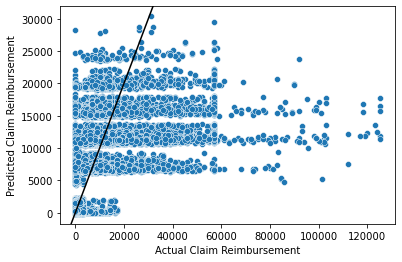

In [146]:
# Filter down our data
data = claims.filter(["Source", 'InscClaimAmtReimbursed',
                      'ClaimStartDt', 'ClaimEndDt','OperatingPhysician','OtherPhysician',
                      'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
                      'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
                       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
                       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
                       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
                       'ClmProcedureCode_6','RenalDiseaseIndicator','ChronicCond_Alzheimer',
                       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
                       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
                       'ChronicCond_Depression', 'ChronicCond_Diabetes',
                       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
                       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'])

# select cohronic columns and modify
chronic        = data.filter(like='Chronic').columns
data[chronic]  = data[chronic] - 1

# engineer features
data['claim_length']    = ((pd.to_datetime(data['ClaimEndDt']) - pd.to_datetime(data['ClaimStartDt'])).dt.days) +1
data['diag_code_count'] = data.filter(like="ClmDiagnosisCode_").count(axis=1)
data['proc_code_count'] = data.filter(like="ClmProcedureCode_").count(axis=1)
data['doc_count']       = data.filter(like='Physician').count(axis=1)
data['chronic_count']   = data.filter(['RenalDiseaseIndicator','ChronicCond_Alzheimer','ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
                       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes',
                       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']
                                     ).sum(axis=1)

# Drop categorical and date features
data = data.drop(['ClaimStartDt', 'ClaimEndDt','OperatingPhysician','OtherPhysician',
                      'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
                      'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
                       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
                       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
                       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
                       'ClmProcedureCode_6'],axis=1)

# Clean Renal Disease Indicator and Source column
data           = data.replace({"Y":1})
data['Source'] = data.Source.replace({"Outpatient":0,"Inpatient":1})

target = data.InscClaimAmtReimbursed
data = data.drop("InscClaimAmtReimbursed",axis=1)


# Model, fit, predict and plot.
from sklearn.linear_model import LinearRegression

LR = LinearRegression()

LR.fit(X= data, y = target)

predicted = LR.predict(data)
sns.scatterplot(x=target, y = predicted )
plt.axline([0,0], slope = 1,c='k')
plt.xlabel('Actual Claim Reimbursement')
plt.ylabel("Predicted Claim Reimbursement")
print(LR.score(X=data, y=target))

## Cummulative Features <a id = "cummfeat"></a>

We want to use information from multive claims to inform our analysis will keeping in mind out analysis will be coming in sequentially. It doesnt make sense to use an observation from November to make a judgement about a case in May. Below I engineering some accumulating features which mimic the drip-drip of claims coming in as the year progresses. 

In [ ]:
# nth claim in the dataset
cummulative_claims  = claims.sort_values('ClaimStartDt').groupby('BeneID').cumcount() +1 #make human readable

# nth claim with each provider in dataset
patient_prov_claims = claims.sort_values('ClaimStartDt').groupby(['BeneID','Provider']).cumcount() +1 #make human readable

# total providers seen so far
total_prov_seen     = claims.sort_values('ClaimStartDt').groupby(['BeneID'])\
                                .Provider.apply(lambda x:(~pd.Series(x).duplicated()).cumsum())

# total claim days
total_claim_days = claims.sort_values('ClaimStartDt').groupby(['BeneID'])['claim_length'].cumsum()

# nth inpatient & outpatient
cummulative_visit_by_type  = claims.sort_values('ClaimStartDt').groupby(['BeneID','Source']).cumcount()

# running total of reimbursement & deductable
cummulative_reimbursement = claims.sort_values('ClaimStartDt').groupby(['BeneID'])['InscClaimAmtReimbursed'].cumsum()
cummulative_deductable    = claims.sort_values('ClaimStartDt').groupby(['BeneID'])['DeductibleAmtPaid'].cumsum()

# running total of 


## Data Cleaning & Feature Engineering <a id='clean'></a>

[Back To Top](#top)


In [4]:
def claim_clean(claim_data):
    ''' cleaning the combined claims (inpatient, outpatient, provider, and beneficiary)
    imputing nulls, shifting some of the values. 
    
    
    '''
    
    #Replace Renal Indicator with 0/1 notation.
    claim_data['RenalDiseaseIndicator'] = claim_data.RenalDiseaseIndicator.replace({"Y":1}).astype(int)
    
    # Recode Chonic conditions to 0/1 notation
    chronic_cols = claim_data.filter(like='ChronicCond').columns
    claim_data[chronic_cols] = claim_data[chronic_cols] - 1
    
    # Changing Source to 0/1 with rename
    claim_data['Source_Inpatient'] = claim_data.Source.replace({"Outpatient":0,"Inpatient":1})
    claim_data                     = claim_data.drop('Source',axis=1)
    
    # Setting Date as Type for Date columns
    date_cols  = ['DOD',"DOB","ClaimStartDt","ClaimEndDt","AdmissionDt",'DischargeDt']
    claim_data[date_cols] = claim_data[date_cols].apply(pd.to_datetime) 
    
    # Setting Missing Dedutible Amt Paid to 0
    claim_data['DeductibleAmtPaid'] = claim_data['DeductibleAmtPaid'].fillna(0)
    
    # Correcting Potential Fraud to 0/1 notation
    claim_data.PotentialFraud = claim_data.PotentialFraud.replace({"Yes":1,"No":0})
    
    
    # Dropping Race & Gender
    claim_data = claim_data.drop(['Race',"Gender"],axis=1)
    
    
    return(claim_data)
    
    
def feat_eng(claim_data, dummify = False):
    chronic_cols = ['RenalDiseaseIndicator','ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
                   'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
                   'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
                   'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
                   'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                   'ChronicCond_stroke']
    
    # Count of Chronic conditions
    claim_data['chronic_count'] = claim_data.filter(items = chronic_cols).sum(axis=1)
    
    # Codes
    claim_data['diagnosis_count'] = claim_data.filter(like="ClmDiagnosisCode_").count(axis=1)
    claim_data['procedure_count'] = claim_data.filter(like="ClmProcedureCode_").count(axis=1)
    claim_data['total_code_count'] = claim_data.filter(like="Code_").count(axis=1)
    
    # Time
    claim_data['age_infered'] = ((claim_data['DOD'].max() - claim_data["DOB"]).dt.days / 365)
    claim_data['death_flag'] = claim_data['DOD'].isnull().astype(int)    
    ## Length of claim, number of days claim occured across (outpatient is usually 1, a 1 night stay = 2 days)
    claim_data['claim_length'] = ((claim_data['ClaimEndDt'] - claim_data['ClaimStartDt']).dt.days) + 1
    ## Impute nan in admission/discharge columns. Our source column is dealing with 
    claim_data['AdmissionDt'] = claim_data['AdmissionDt'].fillna(claim_data['ClaimStartDt'])
    claim_data['DischargeDt'] = claim_data['DischargeDt'].fillna(claim_data['ClaimEndDt'])
    ## Difference (flag and value) between claim start/admission and end/discharge
    claim_data['Admission_not_start'] = (claim_data['ClaimStartDt'] != claim_data['AdmissionDt']).astype(int)
    claim_data['Discharge_not_end']   = (claim_data['ClaimEndDt'] != claim_data['DischargeDt']).astype(int)
    claim_data['Start_Dt_discrepency'] = (claim_data['ClaimStartDt'] - claim_data['AdmissionDt']).dt.days
    claim_data['End_Dt_discrepency'] = (claim_data['ClaimEndDt'] - claim_data['DischargeDt']).dt.days
   
    
    # Physician features
    claim_data['phys_num_role']        = claim_data.filter(like='Physician').count(axis=1)
    claim_data['phys_no_attending']    = claim_data["AttendingPhysician"].isna().astype(int)
    claim_data['phys_no_operating']    = claim_data["OperatingPhysician"].isna().astype(int)
    claim_data['phys_no_other']        = claim_data['OtherPhysician'].isna().astype(int)
    claim_data['num_unique_phys']      = claim_data.filter(like='Physician').nunique(axis=1)
    claim_data['multi_role_phys_flag'] = pd.Series(map(int,[x == y or x==z for x, y, z in list(zip(claim_data.AttendingPhysician, claim_data.OperatingPhysician, claim_data.OtherPhysician))]))
    
    # Cost Features,
    ## Codes & physicans default to 1 if there are none.
    claim_data['total_claim_payment']  = claim_data.filter(["InscClaimAmtReimbursed","DeductibleAmtPaid"]).sum(axis=1)
    claim_data['cost_per_claim_day']   = claim_data.InscClaimAmtReimbursed / claim_data.claim_length
    claim_data['cost_per_diag_code']   = claim_data.InscClaimAmtReimbursed / claim_data.diagnosis_count.replace({0:1})
    claim_data['cost_per_proc_code']   = claim_data.InscClaimAmtReimbursed / claim_data.procedure_count.replace({0:1})
    claim_data['cost_per_code']        = claim_data.InscClaimAmtReimbursed / claim_data.total_code_count.replace({0:1})
    claim_data['cost_per_phys_role']   = claim_data.InscClaimAmtReimbursed / claim_data.phys_num_role.replace({0:1})
    claim_data['cost_per_unique_phys'] = claim_data.InscClaimAmtReimbursed / claim_data.num_unique_phys.replace({0:1})


    # Acummulating Features
    ## Time
    claim_data['days_since_last_claim']     = claim_data.sort_values('ClaimStartDt').groupby('BeneID').ClaimStartDt.diff().dt.days.replace({np.nan:0})
    claim_data['total_claim_days']          = claim_data.sort_values('ClaimStartDt').groupby(['BeneID'])['claim_length'].cumsum()
    ## Claims & Provider
    claim_data['cummulative_claims']        = claim_data.sort_values('ClaimStartDt').groupby('BeneID').cumcount() +1 #make human readable
    claim_data['patient_prov_claims']       = claim_data.sort_values('ClaimStartDt').groupby(['BeneID','Provider']).cumcount() +1 #make human readable
    claim_data['cummulative_prov_seen']     = claim_data.sort_values('ClaimStartDt').groupby(['BeneID'])\
                                                            .Provider.apply(lambda x:(~pd.Series(x).duplicated()).cumsum())
    claim_data['cummulative_visit_by_type'] = claim_data.sort_values('ClaimStartDt').groupby(['BeneID','Source_Inpatient']).cumcount()
    ## Price
    claim_data['cummulative_reimbursement'] = claim_data.sort_values('ClaimStartDt').groupby(['BeneID'])['InscClaimAmtReimbursed'].cumsum()
    claim_data['cummulative_deductable']    = claim_data.sort_values('ClaimStartDt').groupby(['BeneID'])['DeductibleAmtPaid'].cumsum()
    

    # Droping columns that wont be useful
    claim_data = claim_data.drop(['ClaimStartDt','ClaimEndDt'], axis = 1)
    claim_data = claim_data.drop(['DOB','DOD'],                 axis = 1)
    claim_data = claim_data.drop(['AdmissionDt','DischargeDt'], axis = 1)
    code_cols  = claim_data.filter(like="Code_").columns
    claim_data = claim_data.drop(code_cols,axis=1)
    claim_data = claim_data.drop(['ClmAdmitDiagnosisCode', 'DiagnosisGroupCode'],axis=1)
    
    if (dummify):
        for x in ["State","County"]:
            claim_data[x] = pd.get_dummies(claim_data[x], prefix=x)
            
    return(claim_data)

    
def drop_nonusefuls(data):
    cols_to_drop = ['BeneID','ClaimID','Provider','AttendingPhysician', 
                    'OperatingPhysician', 'OtherPhysician',
                    'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
                    'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt',
                    'PotentialFraud','NoOfMonths_PartACov',"NoOfMonths_PartBCov"]
    dropped_data = data.drop(labels = cols_to_drop, axis =1) 
    target = data['PotentialFraud']
    return (dropped_data, target)



# Data Prep <a id='prep'></a>

[Back To Top](#top)

In [5]:
claims = create_claims()

def data_prep(to_prep):
    cleaned = claim_clean(to_prep)
    engineered = feat_eng(cleaned)
        
    data, target =  drop_nonusefuls(engineered)

    return (data, target)


prepped_data, target =  data_prep(claims)


## Multicollinearity <a id='mcl'></a>

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


vif = pd.DataFrame()
vif['Feature'] = prepped_data.columns
vif['VIF']     = [variance_inflation_factor(prepped_data.values, x) for x in range(len(prepped_data.columns)) ]

vif = vif.replace({np.inf:1000})
vif = vif.sort_values('VIF',ascending=False)

C:\Users\James\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


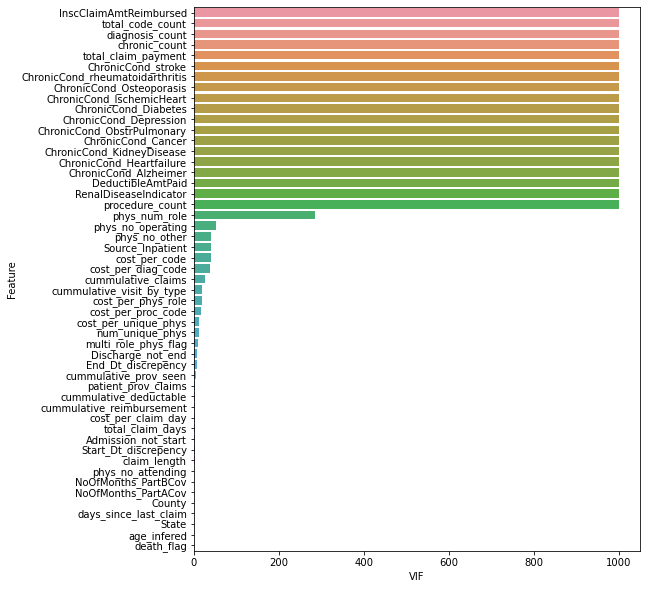

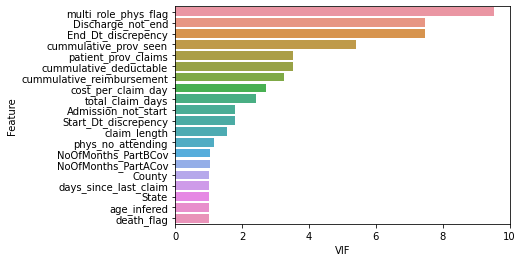

Percent of Columns with "acceptable" vif: 0.39


In [31]:
plt.figure(figsize=(8,10))
sns.barplot(x=vif.VIF, y = vif.Feature)
plt.show()

sns.barplot(x='VIF',y='Feature',data=vif[vif.VIF <10])
plt.show()

print('Percent of Columns with "acceptable" vif: {:.2f}'.format(vif[vif.VIF <10].shape[0]/vif.shape[0]))

## Encoding <a id='encoding'></a>

Linear and (some) Tree based models both need standardized data to make accuarte predictions and avoid overfitting. Since our data was fairly clean beforehand, we only need to fill missing data, and engineer our features, then Encoders can be applied to tbarplots data. 

Below a PowerTransformer (standarizes numeric variables) is applied then for linear models, State and County are broken out into individual columns via OneHotEncoding. Since tree based models are robust against categorical features they dont need the OneHot encoding. 

Boolean features are left unmodified. 

In [42]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, PowerTransformer

# Data to Standardize
numeric_cols = ['InscClaimAmtReimbursed','DeductibleAmtPaid',
                'chronic_count','diagnosis_count', 'procedure_count', 'total_code_count', 'age_infered', 'claim_length',
                'Start_Dt_discrepency','End_Dt_discrepency','phys_num_role','num_unique_phys','total_claim_payment',
                'cost_per_claim_day', 'cost_per_diag_code','cost_per_proc_code', 'cost_per_code', 'cost_per_phys_role',
                'cost_per_unique_phys', 'days_since_last_claim', 'total_claim_days',
                'cummulative_claims', 'patient_prov_claims', 'cummulative_prov_seen',
                'cummulative_visit_by_type', 'cummulative_reimbursement','cummulative_deductable']
nominal_cols = ['State','County']

power_t = PowerTransformer()


prepped_data[numeric_cols] = power_t.fit_transform(prepped_data[numeric_cols])
tree_data = prepped_data

OHencod = OneHotEncoder(drop=None, sparse=False,)
OHE_data = OHencod.fit_transform(prepped_data[nominal_cols])
OHE_cols = OHencod.get_feature_names()
linear_data = pd.concat([prepped_data,pd.DataFrame(OHE_data,columns = OHE_cols)],axis=1)
linear_data = linear_data.drop(nominal_cols, axis=1)


# Modeling <a id='model'></a>

[Back To Top](#top)


In [400]:
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE, SMOTENC

from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, StratifiedShuffleSplit
from scipy.stats import uniform, randint, loguniform

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, auc, roc_curve, RocCurveDisplay
from sklearn.inspection import permutation_importance

## Train-Test Split <a id='split'></a>

In [44]:
train_idx, test_idx = train_test_split(claims.index, test_size=0.3, stratify=target)

print("Natural Mean: {:.2f}".format(target.mean()))
print("Post Split Mean: {:.2f}".format(target[train_idx].mean()))


tree_train   = tree_data.iloc[train_idx,:]
tree_test    = tree_data.iloc[test_idx,:]
target_train = target[train_idx]
target_test  = target[test_idx]



Natural Mean: 0.38
Post Split Mean: 0.38


## Upsampling <a id='upsampling'></a>

- [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
- [SMOTE-NC](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html)
- [Various SMOTE methods](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/)
- [SMOTE-TOMEK](https://imbalanced-learn.org/dev/references/generated/imblearn.combine.SMOTETomek.html)
- [sigh](https://arxiv.org/abs/2103.07612)


Smote-ENN downsamples new values which are intermixed with the other class, since we expect most claims are non-fraudulent this strategy is especially useful. 

Tomek only trims points between the classes, highlighting the edge of the distribution.

#### SMOTE 

In [46]:
%%time
# 5min
smt = SMOTE(n_jobs=-1)
tree_train_smote , target_train_smote = smt.fit_resample(X=tree_train,y= target_train)

print("Unmodified Average: {:.2f}".format(target_train.mean()))
print("After SMOTE: {:.2f}".format(target_train_smote.mean()))

print('old value counts:\n {}'.format(target_train.value_counts()))
print("SMOTE Value counts:\n {}".format(target_train_smote.value_counts()))

Unmodified Average: 0.38
After SMOTE: 0.50
old value counts:
 0    241790
1    148957
Name: PotentialFraud, dtype: int64
SMOTE Value counts:
 0    241790
1    241790
Name: PotentialFraud, dtype: int64
Wall time: 5min 20s


#### SMOTE-NC

In [47]:
%%time
# 30 min
cat_feats = ['State','County','RenalDiseaseIndicator', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
             'ChronicCond_KidneyDisease', 'ChronicCond_Cancer','ChronicCond_ObstrPulmonary', 
             'ChronicCond_Depression','ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
             'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis','ChronicCond_stroke',
             'Source_Inpatient','death_flag','Admission_not_start','Discharge_not_end',
             'phys_no_attending', 'phys_no_operating','phys_no_other','multi_role_phys_flag']

cat_indx = [tree_data.columns.get_loc(x) for x in cat_feats]

smtnc = SMOTENC(categorical_features=cat_indx, n_jobs=-1)
tree_train_smtnc , target_train_smtnc = smtnc.fit_resample(X=tree_train,y= target_train)

print("Unmodified Average: {:.2f}".format(target_train.mean()))
print("After SMOTE-NC: {:.2f}".format(target_train_smtnc.mean()))

print('old value counts:\n {}'.format(target_train.value_counts()))
print("SMOTE-NC Value counts:\n {}".format(target_train_smtnc.value_counts()))

Unmodified Average: 0.38
After SMOTE-NC: 0.50
old value counts:
 0    241790
1    148957
Name: PotentialFraud, dtype: int64
SMOTE-NC Value counts:
 0    241790
1    241790
Name: PotentialFraud, dtype: int64
Wall time: 31min 46s


#### SMOTE-Tomek

In [141]:
# Skip the wait and load data directly
try:
    tree_train_smtmk.to_csv("./data/smote_tomek.csv")
except:
    tree_train_smtmk = pd.read_csv("./data/smote_tomek.csv")

In [48]:
%%time
# 1 hr 40 min

smtmk = SMOTETomek(n_jobs=-1)
tree_train_smtmk , target_train_smtmk = smtmk.fit_resample(X=tree_train,y= target_train)

print("Unmodified Average: {:.2f}".format(target_train.mean()))
print("After SMOTE-Tomek: {:.2f}".format(target_train_smtmk.mean()))

print('old value counts:\n {}'.format(target_train.value_counts()))
print("SMOTE-Tomek Value counts:\n {}".format(target_train_smtmk.value_counts()))

Unmodified Average: 0.38
After SMOTE-Tomek: 0.50
old value counts:
 0    241790
1    148957
Name: PotentialFraud, dtype: int64
SMOTE-Tomek Value counts:
 0    231010
1    231010
Name: PotentialFraud, dtype: int64
Wall time: 1h 44min 12s


#### Analysis of upsampled data

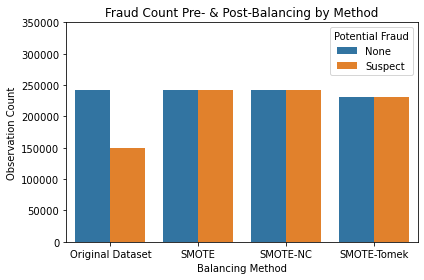

In [49]:
origin  = target_train.value_counts().reset_index()
smote   = target_train_smote.value_counts().reset_index()
smotenc = target_train_smtnc.value_counts().reset_index()
tomek   = target_train_smtmk.value_counts().reset_index()
upsampling = pd.concat([origin,smote,smotenc, tomek],axis = 0).rename({"index":"Potential Fraud","PotentialFraud":"Observation Count"},axis=1)
upsampling['Sampling Method'] = ["Original Dataset"]*2 +["SMOTE"]*2 + ["SMOTE-NC"]*2 + ["SMOTE-Tomek"]*2
upsampling = upsampling.replace({"Potential Fraud":{0:"None",1:"Suspect"}})



sns.barplot(x='Sampling Method',
            y="Observation Count",
            hue='Potential Fraud',
            data = upsampling)
plt.ylim(0,350000)
plt.title("Fraud Count Pre- & Post-Balancing by Method")
plt.xlabel("Balancing Method")
plt.tight_layout()
plt.savefig('./graphics/post_sampling.png')


## First Pass Modeling <a id='firstpass'></a>

In [90]:
def first_pass_modeling(model, data, target):
    cv = StratifiedShuffleSplit()
    scorers = []
    return cross_val_score(model,data,target,cv=cv, n_jobs=-1)
    #return cross_val_score(model,data,target,cv=cv, n_jobs=-1, scoring=scorers)


def compare_upsamples(model,data_sets,names,targets):
    results = pd.DataFrame()
    for data, target, name in zip(data_sets,targets, names):
        cv_scores = first_pass_modeling(model,data, target)
        named_score = pd.concat([pd.Series(cv_scores),pd.Series([name]*len(cv_scores))],axis=1)
        results = pd.concat([results,named_score],axis=0)
        print('Fit model to {} data'.format(name))
    return results
    
    
# Linear Classifiers
#model_logit = LogisticRegression()
#model_SVC   = SVC()

# Other Type
#model_KNNC  = KNeighborsClassifier() # takes a while to run
#model_MLPC  = MLPClassifier()

# Tree Classifiers
model_RF    = RandomForestClassifier()
model_GB    = GradientBoostingClassifier()
model_XGB   = XGBClassifier()
model_CB    = CatBoostClassifier()


data_sets = [tree_train,   tree_train_smote,   tree_train_smtnc,   tree_train_smtmk]
targets   = [target_train, target_train_smote, target_train_smtnc, target_train_smtmk]
names     = ["Original", "SMOTE", "SMOTE-NC","SMOTE-Tomek"]
    

#### Random Forest

In [86]:
%%time

# 20 minutes
RF_cvs = compare_upsamples(model_RF, data_sets, names, targets)
RF_cvs

# 4 minutes
#first_pass_modeling(model_RF, tree_train,target_train)
# what does this represent?
#      [0.70538708, 0.70223928, 0.70200896, 0.7028023 , 0.70653871,0.70244402, 0.70257198, 0.70510557, 0.70295585, 0.70497761]

Wall time: 23min 46s


,0,1
0,0.703417,Original
1,0.705080,Original
2,0.706513,Original
3,0.706360,Original
4,0.703314,Original
5,0.704568,Original
6,0.706180,Original
7,0.707767,Original
8,0.701395,Original
9,0.704338,Original


#### Gradient Boost

In [91]:
%%time

# 30 minutes
GB_cvs = compare_upsamples(model_GB, data_sets, names, targets)
GB_cvs


# 6 minutes
#first_pass_modeling(model_GB, tree_train,target_train)
# 
#GB_cv = [0.70252079, 0.70269994, 0.70269994, 0.70211132, 0.70080614, 0.70298145, 0.69927063, 0.70049904, 0.69758157, 0.69924504]

Fit model to Original data
Fit model to SMOTE data
Fit model to SMOTE-NC data
Fit model to SMOTE-Tomek data
Wall time: 33min 13s


,0,1
0,0.703289,Original
1,0.697658,Original
2,0.703365,Original
3,0.702572,Original
4,0.701548,Original
5,0.701318,Original
6,0.700960,Original
7,0.699194,Original
8,0.699808,Original
9,0.702342,Original


#### XGBoost

In [93]:
%%time

# 12 minutes
XGB_cvs = compare_upsamples(model_XGB, data_sets, names, targets)
XGB_cvs

# 2 minutes
#first_pass_modeling(model_XGB,tree_train,target_train)
#
# XGB_cv = [0.77696737, 0.7771721 , 0.77456174, 0.77683941, 0.77712092, 0.77599488, 0.77497121, 0.77507358, 0.77824696, 0.77376839]

Fit model to Original data
Fit model to SMOTE data
Fit model to SMOTE-NC data
Fit model to SMOTE-Tomek data
Wall time: 11min 53s


,0,1
0,0.779552,Original
1,0.774434,Original
2,0.772949,Original
3,0.777684,Original
4,0.778145,Original
5,0.778017,Original
6,0.774280,Original
7,0.777735,Original
8,0.777249,Original
9,0.777249,Original


#### Catboost

In [94]:
%%time

# minutes
CB_cvs = compare_upsamples(model_CB, data_sets, names, targets)
CB_cvs


# 4 minutes
#first_pass_modeling(model_CB, tree_train,target_train)
#
# CB_cv = [0.77860525, 0.77901472, 0.77658349, 0.77819578, nan, nan, 0.779373  , 0.78103647, 0.779373  , 0.77660909]

Fit model to Original data
Fit model to SMOTE data
Fit model to SMOTE-NC data
Fit model to SMOTE-Tomek data
Wall time: 22min 6s


,0,1
0,0.777633,Original
1,0.778733,Original
2,0.776225,Original
3,0.778784,Original
4,0.776814,Original
5,0.773820,Original
6,0.776404,Original
7,0.778656,Original
8,0.779322,Original
9,0.774843,Original


#### Model Assessments

In [134]:
try:
    RF_cvs["Model"]  = 'Random Forest'
    GB_cvs["Model"]  = 'Gradient Boost'
    XGB_cvs["Model"] = 'XGBoost'
    CB_cvs['Model']  = 'CatBoost'


    naive_scores = pd.concat([RF_cvs, GB_cvs, XGB_cvs, CB_cvs],axis=0)
    naive_scores.columns = ["Score","Data Set","Model"]
    
    naive_scores.to_csv("./data/naive_scores.csv",index=False)
    
except:
    naive_scores = pd.read_csv("./data/naive_scores.csv")

naive_scores


,Score,Data Set,Model
0,0.703417,Original,Random Forest
1,0.705080,Original,Random Forest
2,0.706513,Original,Random Forest
3,0.706360,Original,Random Forest
4,0.703314,Original,Random Forest
...,...,...,...
5,0.827410,SMOTE-Tomek,CatBoost
6,0.828557,SMOTE-Tomek,CatBoost
7,0.825808,SMOTE-Tomek,CatBoost
8,0.828146,SMOTE-Tomek,CatBoost


<ipython-input-223-72d93d5b6371>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(["{}%".format(y) for y in yticks])


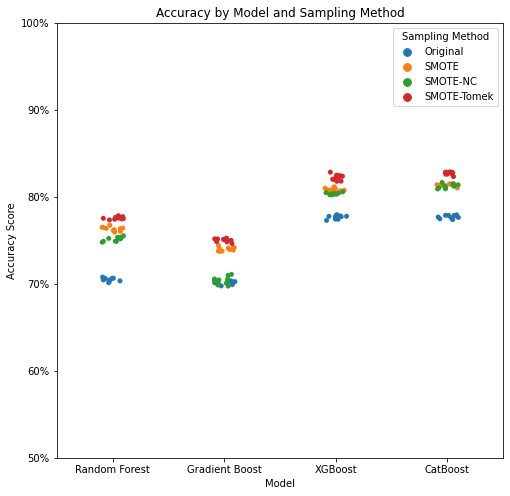

In [223]:
plt.figure(figsize=(8,8))
#plt.tight_layout()
plot = sns.stripplot(x= "Model", y='Score', hue='Data Set', data = naive_scores)
#plot = sns.swarmplot(x= "Model", y='Score', hue='Data Set', data = naive_scores)
plot.set_ylim(0.5,1)
plot.set_ylabel("Accuracy Score")
yticks = range(50,101,10)
plot.set_yticklabels(["{}%".format(y) for y in yticks])

plot.set_title("Accuracy by Model and Sampling Method")
plot.legend(title='Sampling Method')

plt.savefig("./graphics/naive_scores.png")



Some information about XGBoost/ catboost, how are these doing?

## Hyperparameter Tuning <a id='tuning'></a>

In [322]:
%%time

model_XGB = XGBClassifier(n_jobs=-1, use_label_encoder=False)
model_CB  = CatBoostClassifier()


XGB_params = {'learning_rate': uniform(loc=0, scale=0.2), #[0.01, 0.1, 0.3],
             'gamma': loguniform(10**-3, 10**2),          #np.logspace(-2,3,3).tolist()+[0],
             'max_depth': randint(low=3, high=8),         #[3,6,8],
             'subsample': uniform(loc=0.5, scale=1),      #[0.5,0.75,1],
             'min_child_weight': randint(low=4, high=12)} #[4,8,12]}

CB_params  = {'learning_rate':  loguniform(10**-3,3**-1),  #[0.001, 0.01, 0.1, 0.3],
              'depth': randint(low=4,high=10),            #[4,6,10],
              'l2_leaf_reg': randint(low=1,high=9)}       #[1,3,5,7,9]}



cvXGB = RandomizedSearchCV(model_XGB, XGB_params, n_iter = 50, scoring = 'accuracy', cv=10, n_jobs=-1)
cvCB  = RandomizedSearchCV(model_CB,  CB_params,  n_iter = 50, scoring = 'accuracy', cv=10, n_jobs=-1)
#cvXGB = RandomizedSearchCV(model_XGB, XGB_params, n_iter = 50, scoring = 'recall', cv=10, n_jobs=-1)
#cvCB  = RandomizedSearchCV(model_CB,  CB_params,  n_iter = 50, scoring = 'recall', cv=10, n_jobs=-1)


print("Starting XGBoost HyPrm Search")
XGB_search = cvXGB.fit(tree_train_smtmk, target_train_smtmk) 

print("Starting CatBoost HyPrm Search")
CB_search  = cvCB.fit(tree_train_smtmk, target_train_smtmk) 


Starting XGBoost HyPrm Search


C:\Users\James\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.71355785 0.70941518 0.68175837        nan 0.73124107 0.69327735
        nan 0.6656595         nan        nan 0.67311805 0.70109519
        nan        nan 0.65082031 0.6470629         nan 0.6924895
 0.71588676 0.64125363        nan        nan 0.68348556        nan
 0.63149647        nan        nan 0.68421713        nan 0.63882083
 0.63795074        nan        nan        nan 0.67588416 0.64472534
 0.69063244        nan 0.50571837        nan        nan        nan
        nan        nan        nan 0.64343968        nan        nan
        nan        nan]
  warnings.warn(


[23:38:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting CatBoost HyPrm Search
0:	learn: 0.6377252	total: 91.5ms	remaining: 1m 31s
1:	learn: 0.6096694	total: 174ms	remaining: 1m 26s
2:	learn: 0.5927576	total: 266ms	remaining: 1m 28s
3:	learn: 0.5787220	total: 363ms	remaining: 1m 30s
4:	learn: 0.5566013	total: 455ms	remaining: 1m 30s
5:	learn: 0.5500900	total: 539ms	remaining: 1m 29s
6:	learn: 0.5328197	total: 628ms	remaining: 1m 29s
7:	learn: 0.5209785	total: 718ms	remaining: 1m 29s
8:	learn: 0.5138502	total: 807ms	remaining: 1m 28s
9:	learn: 0.5077675	total: 890ms	remaining: 1m 28s
10:	learn: 0.5043391	total: 974ms	remaining: 1m 27s
11:	learn: 0.5010529	total: 1.06s	remaining: 1m 27s
12:	learn: 0.4938848	total: 1.15s	remaining:

## Model Analysis <a id='model_analysis'></a>

In [323]:
tuned_XB = XGB_search.best_estimator_
tuned_CB = CB_search.best_estimator_

#### Metrics

In [324]:
def metric_wrapper(y_true,y_pred):
    results = {}
    
    #results["confusion_matrix"] = confusion_matrix(y_true, y_pred) 
    results["accuracy_score"]   = accuracy_score(y_true, y_pred)
    results["recall_score"]     = recall_score(y_true, y_pred)
    results["precision_score"]  = precision_score(y_true, y_pred)
    results["f1_score"]         = f1_score(y_true, y_pred)
    
    return results

In [342]:
y_pred_XB_train = tuned_XB.predict(X=tree_train_smtmk)
y_pred_CB_train = tuned_CB.predict(data=tree_train_smtmk)

y_pred_XB_test = tuned_XB.predict(X=tree_test)
y_pred_CB_test = tuned_CB.predict(data=tree_test)


metrics = {}
metrics['XGBoost Train'] = metric_wrapper(target_train_smtmk, y_pred_XB_train)
metrics['XGBoost Test']  = metric_wrapper(target_test, y_pred_XB_test)

metrics['CatBoost Train'] = metric_wrapper(target_train_smtmk, y_pred_CB_train)
metrics['CatBoost Test']  = metric_wrapper(target_test, y_pred_CB_test)


metrics = pd.DataFrame(metrics).transpose().reset_index()
metrics[['Model','Data']] = metrics['index'].str.split(expand=True)
metrics = metrics.drop('index',axis=1)\
                    .melt(id_vars = ['Model',"Data"], 
                          value_vars = ['accuracy_score','recall_score',"precision_score","f1_score"],
                          value_name="Value",
                          var_name="Metric")

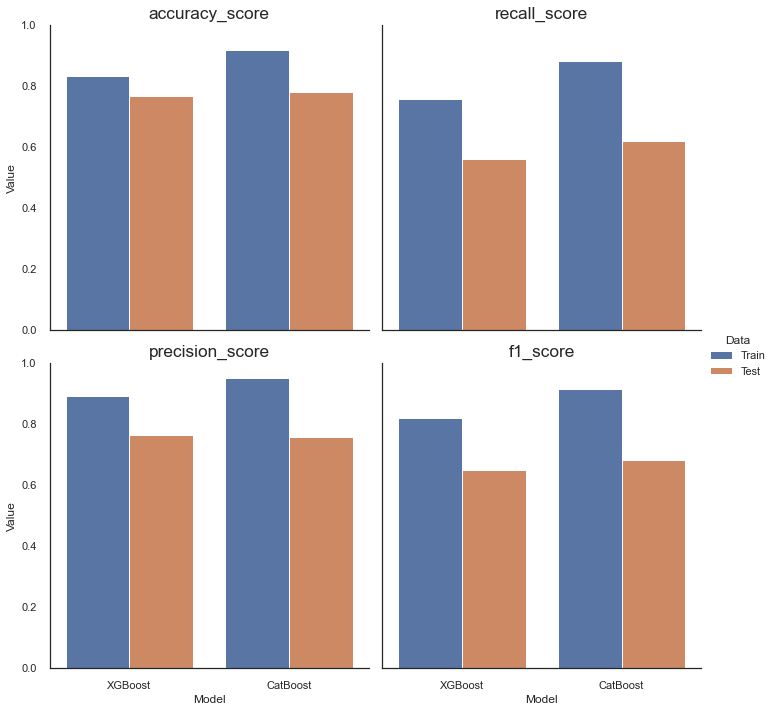

In [570]:
plot = sns.catplot(x = "Model", 
            y = "Value", 
            hue = "Data", 
            data = metrics, 
            col = 'Metric',
            col_wrap = 2, 
            kind = 'bar',sharey=True)
plt.ylim(0,1)
plot.set_titles(col_template='{col_name}',size='x-large')



#### Confusion Matrix

In [377]:
y_pred_XB_train, y_pred_XB_test = map(lambda x: tuned_XB.predict(X=x), [tree_train_smtmk, tree_test])
y_pred_CB_train, y_pred_CB_test = map(lambda x: tuned_CB.predict(data=x), [tree_train_smtmk, tree_test])

def simple_heatmap(y_actual, y_pred, norm = None):
    norm = norm if np.isnan(norm) else 'all'
    matrix = confusion_matrix(y_actual, y_pred, normalize = norm)
    
    plot = sns.heatmap(data = matrix,
                       annot=True, 
                       fmt='.2%',
                       cmap='OrRd')
    return plot

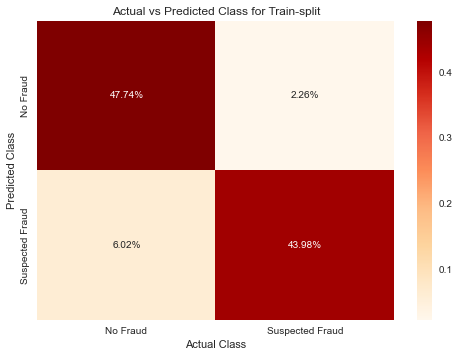

accuracy_score: 0.92
recall_score: 0.88
precision_score: 0.95
f1_score: 0.91


<Figure size 576x396 with 0 Axes>

In [386]:
CB_train_cm = simple_heatmap(target_train_smtmk, y_pred_CB_train, norm = True)


CB_train_cm.set_xlabel("Actual Class")
CB_train_cm.set_ylabel("Predicted Class")
CB_train_cm.set_title("Actual vs Predicted Class for Train-split")
ticks = ['No Fraud','Suspected Fraud']
CB_train_cm.set_yticklabels(ticks)
CB_train_cm.set_xticklabels(ticks)
plt.show()
plt.savefig("./graphics/CB_confusionmatrix_train.png")

pred_info = metric_wrapper(target_train_smtmk, y_pred_CB_train)
for item in pred_info.items():
    print("{}: {:.2f}".format(item[0],item[1]))



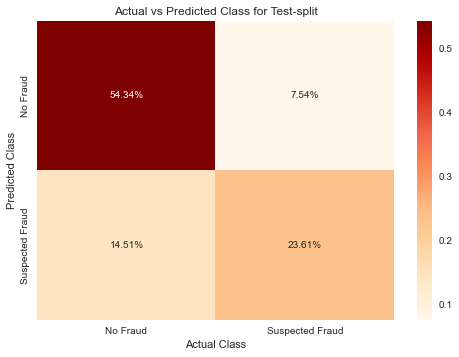

The natural distribution here is 38.12% suspect
accuracy_score: 0.78
recall_score: 0.62
precision_score: 0.76
f1_score: 0.68


<Figure size 576x396 with 0 Axes>

In [387]:
CB_test_cm = simple_heatmap(target_test, y_pred_CB_test, norm = True)


CB_test_cm.set_xlabel("Actual Class")
CB_test_cm.set_ylabel("Predicted Class")
CB_test_cm.set_title("Actual vs Predicted Class for Test-split")
ticks = ['No Fraud','Suspected Fraud']
CB_test_cm.set_yticklabels(ticks)
CB_test_cm.set_xticklabels(ticks)
plt.show()
plt.savefig("./graphics/CB_confusionmatrix_test.png")

print("The natural distribution here is {:.2f}% suspect".format(100*claims.PotentialFraud.mean()))


pred_info = metric_wrapper(target_test, y_pred_CB_test)
for item in pred_info.items():
    print("{}: {:.2f}".format(item[0],item[1]))

#### ROC-AUC Curves

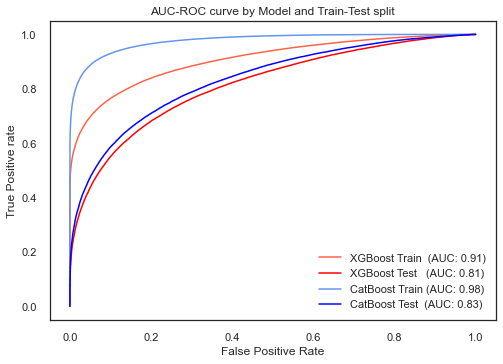

In [571]:
y_pred_1, y_pred_2 = map(lambda data: [x[1] for x in tuned_XB.predict_proba(X=data)],[tree_train_smtmk, tree_test])
y_pred_3, y_pred_4 = map(lambda data: [x[1] for x in tuned_CB.predict_proba(X=data)],[tree_train_smtmk, tree_test])


fpr1, tpr1, t1 = roc_curve(target_train_smtmk, y_pred_1)
fpr2, tpr2, t2 = roc_curve(target_test, y_pred_2)
fpr3, tpr3, t3 = roc_curve(target_train_smtmk, y_pred_3)
fpr4, tpr4, t4 = roc_curve(target_test, y_pred_4)


auc1, auc2, auc3, auc4 = map(lambda x: auc(x[0],x[1]), [(fpr1,tpr1),(fpr2,tpr2),(fpr3,tpr3),(fpr4,tpr4)])

#auc1 = auc(fpr1,tpr1)
#auc2 = auc(fpr2,tpr2)
#auc3 = auc(fpr3,tpr3)
#auc4 = auc(fpr4,tpr4)

plt.plot(fpr1, tpr1, color = "tomato",         label = "XGBoost Train  (AUC: {:.2f})".format(auc1))
plt.plot(fpr2, tpr2, color = "Red",            label = "XGBoost Test   (AUC: {:.2f})".format(auc2))
plt.plot(fpr3, tpr3, color = "cornflowerblue", label = "CatBoost Train (AUC: {:.2f})".format(auc3))
plt.plot(fpr4, tpr4, color = "Blue",           label = "CatBoost Test  (AUC: {:.2f})".format(auc4))

sns.lineplot()

plt.legend(loc='best')

plt.title('AUC-ROC curve by Model and Train-Test split')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.show()

#### Feature Importance

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

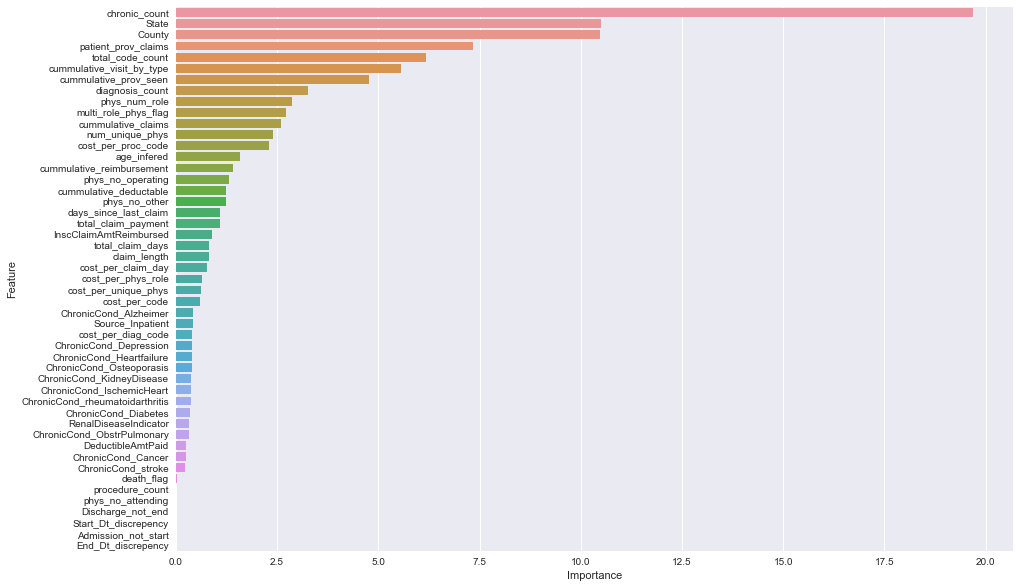

In [398]:
feat_import = pd.DataFrame(zip(tree_train.columns, tuned_CB.feature_importances_),columns=["Feature","Importance"])

plt.figure(figsize=(15,10))
sns.barplot(x="Importance",y="Feature",data=feat_import.sort_values("Importance",ascending=False))

#### Permutation Importance

In [404]:
# ~2min runtime
perm_import = permutation_importance(tuned_CB, tree_test, target_test)

,0,1
0,InscClaimAmtReimbursed,"[0.03987125591171836, 0.03982945588305553, 0.0..."
1,DeductibleAmtPaid,"[0.002513973152438731, 0.0025438303157694353, ..."
2,RenalDiseaseIndicator,"[0.0022930301437921186, 0.0023288587397888305,..."
3,State,"[0.16069125304543064, 0.15921033774423166, 0.1..."
4,County,"[0.13598146467300443, 0.1347394066784503, 0.13..."
5,ChronicCond_Alzheimer,"[0.004054602780299121, 0.004418860172932693, 0..."
6,ChronicCond_Heartfailure,"[0.005069746333540404, 0.005875889743467311, 0..."
7,ChronicCond_KidneyDisease,"[0.003899345530979814, 0.0051055749295371156, ..."
8,ChronicCond_Cancer,"[0.002388573066450128, 0.0025796589117661473, ..."
9,ChronicCond_ObstrPulmonary,"[0.0026811732670902755, 0.0035112024076816573,..."


<AxesSubplot:xlabel='Permutation Importance', ylabel='Feature'>

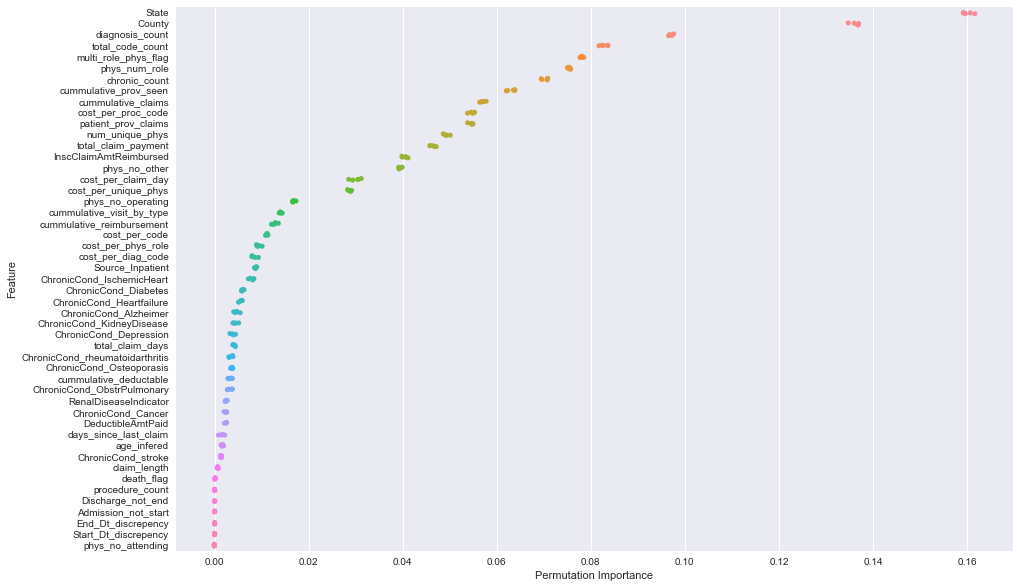

In [420]:
importances    = perm_import['importances']
df_perm_import = pd.DataFrame(dict(zip(tree_test.columns, importances))).melt(var_name="Feature",value_name="Permutation Importance")


plt.figure(figsize=(15,10))
sns.stripplot(x="Permutation Importance",y="Feature",data=df_perm_import.sort_values("Permutation Importance",ascending=False))

# Aggregating Predictions <a id='aggregate'></a>

[Back to Top](#top)


So for our best model, we want to make predictions about the suspectness of each provider. Since we predicted on a per-claim basis, we need to aggregate up to the provider level. Below I use the train and test data to make predictions about a given provider at the nth 

group by provider, sum probabilities across predictions?

In [655]:
#index is preserved.

#2 by n of 0 or 1

def Organize_Predictions(data,target):
    pred_prob = tuned_CB.predict_proba(X=data)
    pred_prob = pd.DataFrame(pred_prob,
                             columns = ['prob_class_0','prob_class_1'],
                             index = target.index)
        
    # Add in other information, actual class, claim end date for sorting, and provider ID
    pred_prob = pd.merge(pred_prob, target.rename('actual_class'), left_index=True, right_index=True)
    pred_prob = pd.merge(pred_prob, claims.ClaimEndDt.rename('ClaimEndDt'), left_index=True, right_index=True)
    pred_prob = pd.merge(pred_prob, claims.Provider.rename("Provider"), left_index=True, right_index=True)
        
    # Create cummulative columns. 
    pred_prob['cummulative_provider_obs'] = pred_prob.sort_values('ClaimEndDt').groupby('Provider').cumcount() + 1 
    pred_prob['cummulative_perc_class_1']  = pred_prob.sort_values("ClaimEndDt").groupby('Provider')['prob_class_1'].cumsum()
    pred_prob['cummulative_mean'] = pred_prob['cummulative_perc_class_1'] / pred_prob['cummulative_provider_obs']
    return pred_prob



train_preds = Organize_Predictions(tree_train, target_train)
test_preds  = Organize_Predictions(tree_test, target_test)


#### Can we learn more with the cummulative prediction?

In [656]:
train_providers = train_preds.sort_values("cummulative_provider_obs", ascending=False).groupby("Provider").head(1)[['actual_class','cummulative_mean']]
train_providers['cummulative_prediction'] = train_providers['cummulative_mean'].round()

test_providers = test_preds.sort_values("cummulative_provider_obs", ascending=False).groupby("Provider").head(1)[['actual_class','cummulative_mean']]
test_providers['cummulative_prediction'] = test_providers['cummulative_mean'].round()

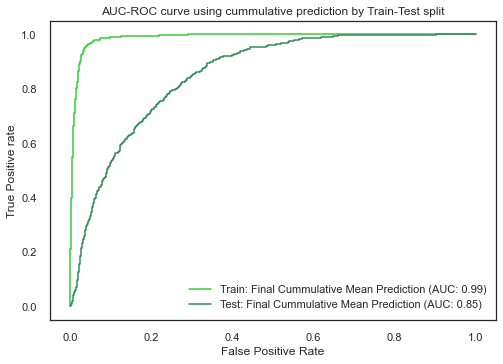

In [662]:
fpr1, tpr1, t1 = roc_curve(train_providers.actual_class, train_providers.cummulative_mean)
fpr2, tpr2, t2 = roc_curve(test_providers.actual_class, test_providers.cummulative_mean)


auc1, auc2 = map(lambda x: auc(x[0],x[1]), [(fpr1,tpr1),(fpr2,tpr2)])


plt.plot(fpr1, tpr1, color = "limegreen", label = "Train: Final Cummulative Mean Prediction (AUC: {:.2f})".format(auc1))
plt.plot(fpr2, tpr2, color = "seagreen",  label = "Test: Final Cummulative Mean Prediction (AUC: {:.2f})".format(auc2))


sns.lineplot()

plt.legend(loc='best')

plt.title('AUC-ROC curve using cummulative prediction by Train-Test split')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.show()

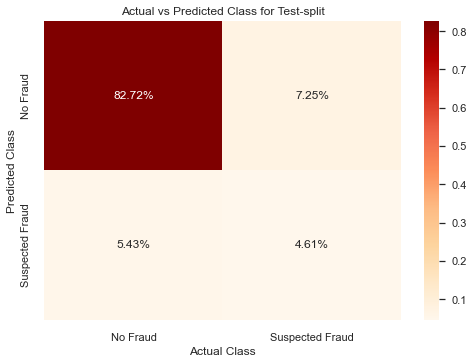

The natural distribution here is 9.35% suspect
accuracy_score: 0.87
recall_score: 0.46
precision_score: 0.39
f1_score: 0.42


In [661]:
cummulative_test = simple_heatmap(test_providers.actual_class, test_providers.cummulative_prediction, norm = True)


cummulative_test.set_xlabel("Actual Class")
cummulative_test.set_ylabel("Predicted Class")
cummulative_test.set_title("Actual vs Predicted Class for Test-split")
ticks = ['No Fraud','Suspected Fraud']
cummulative_test.set_yticklabels(ticks)
cummulative_test.set_xticklabels(ticks)
plt.show()
#plt.savefig("./graphics/cummulative_confusionmatrix_test.png")

print("The natural distribution here is {:.2f}% suspect".format(100*prov_key.PotentialFraud.mean()))


pred_info = metric_wrapper(test_providers.actual_class, test_providers.cummulative_prediction)
for item in pred_info.items():
    print("{}: {:.2f}".format(item[0],item[1]))

#### Cummulative Prediction with nth thresehold.

In [ ]:
data = claims.groupby('Provider').agg({"PotentialFraud":'mean',"ClaimID":'nunique'})


In [ ]:
data_1claim  =
data_5claim  =
data_10claim =
data_50claim = 


fpr1, tpr1, t1 = roc_curve(train_providers.actual_class, train_providers.cummulative_mean)
fpr2, tpr2, t2 = roc_curve(test_providers.actual_class, test_providers.cummulative_mean)
fpr2, tpr2, t2 = roc_curve() #1 claims
fpr2, tpr2, t2 = roc_curve() #5 claims or less
fpr2, tpr2, t2 = roc_curve() #10 claims or less
fpr2, tpr2, t2 = roc_curve() #50 claims or less

pos_rates = [(fpr1,tpr1),(fpr2,tpr2),(),(),(),()]


auc1, auc2 = map(lambda x: auc(x[0],x[1]), [(fpr1,tpr1),(fpr2,tpr2)])


plt.plot(fpr1, tpr1, color = "limegreen", label = "Train: Final Cummulative Mean Prediction (AUC: {:.2f})".format(auc1))
plt.plot(fpr2, tpr2, color = "seagreen",  label = "Test: Final Cummulative Mean Prediction (AUC: {:.2f})".format(auc2))


sns.lineplot()

plt.legend(loc='best')

plt.title('AUC-ROC curve using cummulative prediction by Train-Test split')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.show()

In [580]:
providers_by_claimcount = train_preds.groupby('Provider')\
                                        .agg({"actual_class":'mean',"ClaimEndDt":'count'})\
                                        .rename({"ClaimEndDt":"Claim_counts"},axis=1)\
                                        .sort_values("Claim_counts",ascending=False)

print("Best to take Innocent and Suspect Provider with similar observation counts")
print(providers_by_claimcount.groupby('actual_class').head(1))


print("These two providers have similar submission rates.")
print(providers_by_claimcount[providers_by_claimcount.Claim_counts > 825].sort_values('Claim_counts')[2:4])

Best to take Innocent and Suspect Provider with similar observation counts
          actual_class  Claim_counts
Provider                            
PRV51459             1          5778
PRV53394             0           854
These two providers have similar submission rates.
          actual_class  Claim_counts
Provider                            
PRV52104             0           845
PRV53670             1           847


# Below but with test values

This but with a line tracking the cummulative average

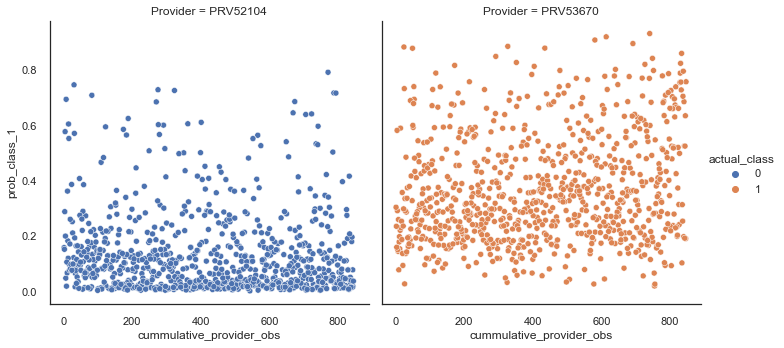

In [590]:
example_providers = train_preds[train_preds.Provider.apply(lambda x: x in ["PRV52104","PRV53670"])]

sns.relplot(y = "prob_class_1",
               x = "cummulative_provider_obs",
               data = example_providers,
              col = "Provider",
              col_order = ["PRV52104","PRV53670"],
              hue = "actual_class"
              )

<AxesSubplot:xlabel='Provider', ylabel='prob_class_1'>

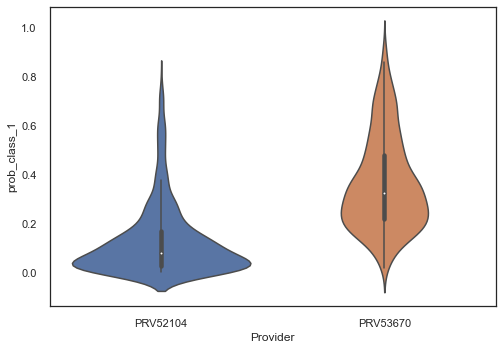

In [620]:
example_providers = train_preds[train_preds.Provider.apply(lambda x: x in ["PRV52104","PRV53670"])]
sns.violinplot(y = "prob_class_1",
               x = "Provider",
               data = example_providers,
              order = ["PRV52104","PRV53670"])

<AxesSubplot:xlabel='actual_class', ylabel='prob_class_1'>

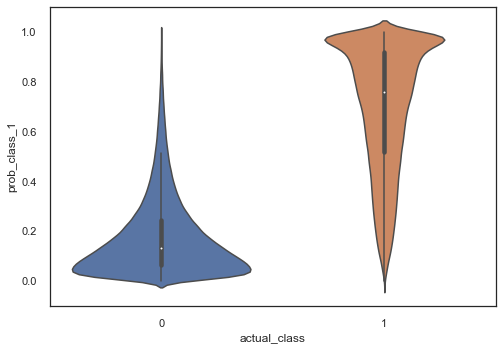

In [621]:
sns.violinplot(y='prob_class_1',
               x='actual_class',
               data = train_preds)

All have over 1000 claims, highest is over 5000

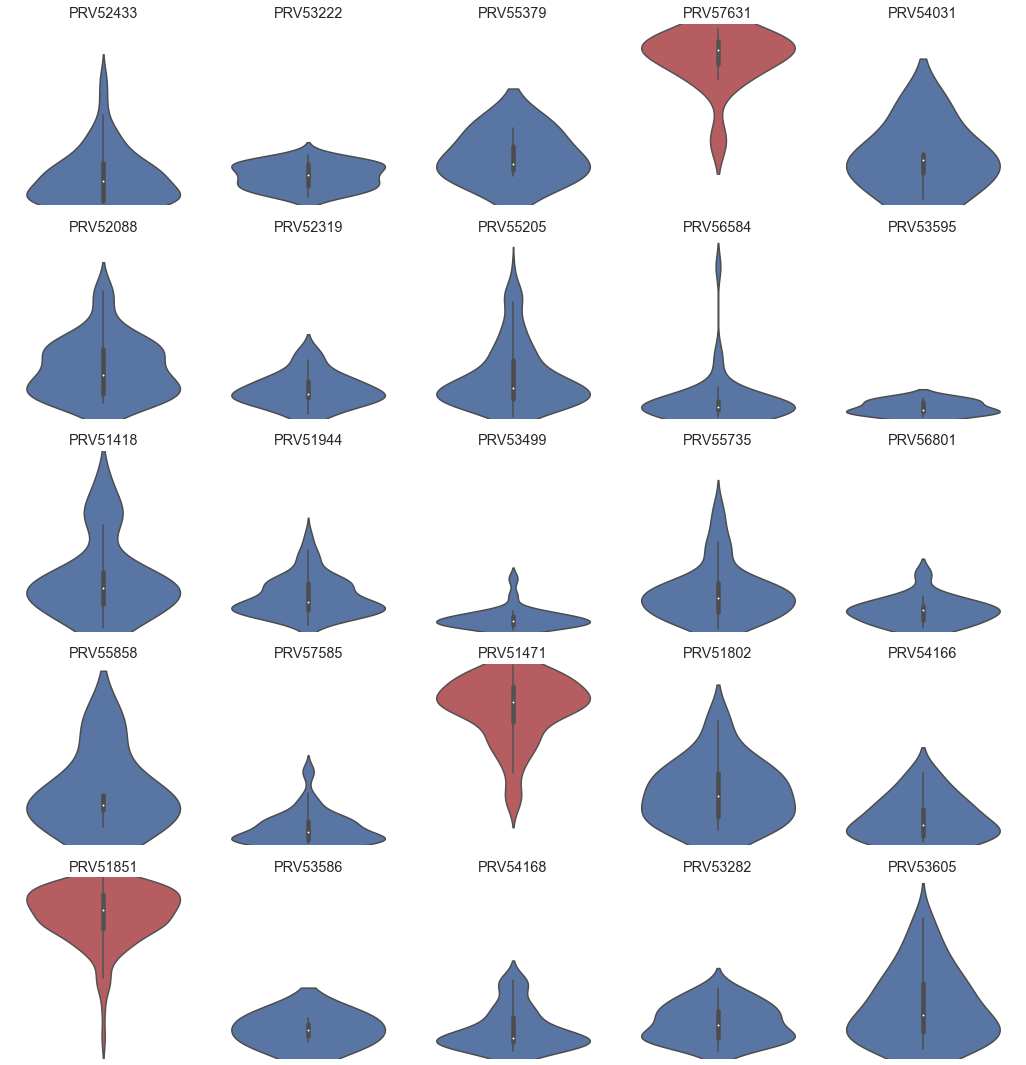

In [689]:
p = sns.FacetGrid(data, 
                  col = 'Provider',
                  hue='actual_class',
                  palette = ['b','r'],
                  col_wrap=5,
                  despine=True,
                  ylim=(0,1))

p.map_dataframe(sns.violinplot, 
                y='prob_class_1',
                orient='v')

p.set_titles(col_template='{col_name}',size='large')

p.despine(bottom=True,left=True)
p.set_yticklabels([])
p.set_ylabels("")


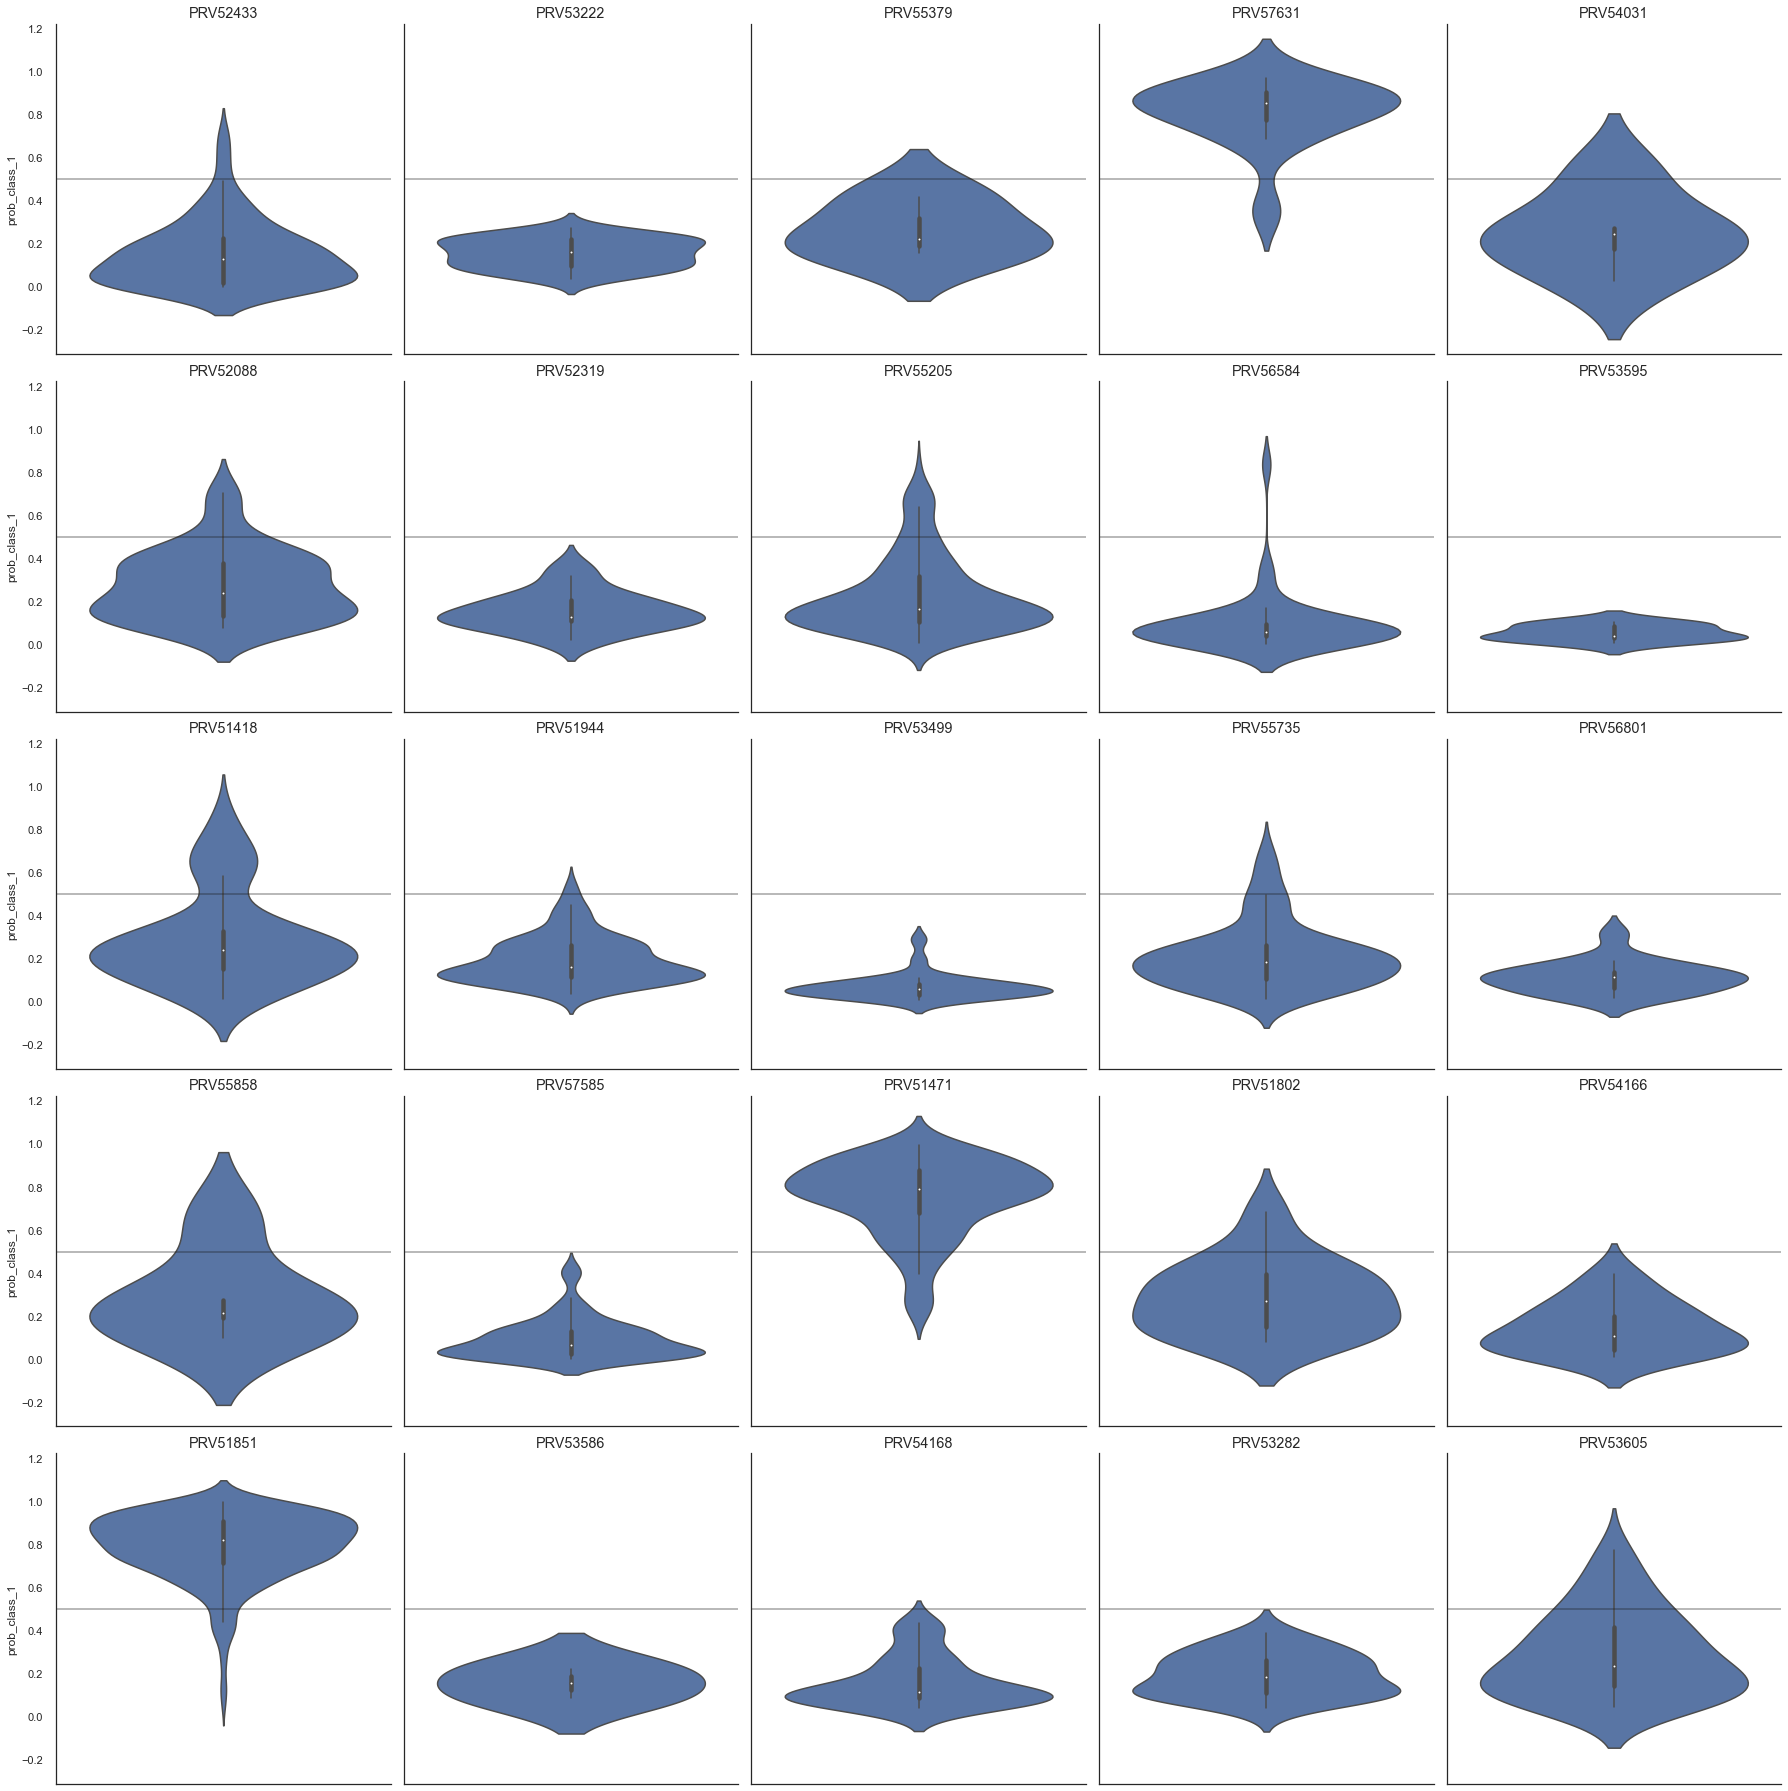

In [671]:
top_25 = train_preds.sort_values("cummulative_provider_obs",ascending = False)["Provider"].unique()[0:25]
bottom_25 = train_preds.sort_values("cummulative_provider_obs",ascending = True)["Provider"].unique()[0:25]

data = train_preds[train_preds.Provider.apply(lambda x: x in bottom_25)].sort_values('cummulative_provider_obs')
data['actual_class'] = data['actual_class'].astype(str)

#cmap = data.groupby("Provider").agg({'actual_class':'mean'})
#cmap = [1 if x else 0 for x in cmap.actual_class ]

sns.set_theme(style='white')
plot = sns.catplot(y='prob_class_1',
            data = data,
            col = 'Provider',
            col_wrap= 5,
            kind = 'violin',
            #palette = cmap
            #hue = 'actual_class',
            #hue_order=None,
            #cut = .5,
            scale = 'count')

plot.set_titles(col_template='{col_name}',size='large')

axes = plot.axes.flatten()

for i, ax in enumerate(axes):
    ax.axhline(0.5,c='k',alpha=0.4)

#sns.despine(bottom = True, left=True)
#plot.set_yticklabels([])
#plot.set_ylabels("")

#plt.savefig("./graphics/top_25_pred_distribution.png")
#plt.savefig("./graphics/bottom_25_pred_distribution.png")